In [ ]:
#Import necessary libraries
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
#Function to read parquet file
def read_parquet_file(file_path):
    df = pd.read_parquet(file_path)
    return df

In [ ]:
#Importing document
file_path = '/Users/salmahoumane/Desktop/data_2024-07-24.parquet'
df = read_parquet_file(file_path)

In [ ]:
# Print the column names
print("Column names:")
print(df.columns)

In [ ]:
# Convert datetime columns to datetime type
df['DESTINATION_SCAN_DATETIME'] = pd.to_datetime(df['DESTINATION_SCAN_DATETIME'])
df['FIRST_SCAN_DATETIME'] = pd.to_datetime(df['FIRST_SCAN_DATETIME'])
# Add a new column for the week of the year
df['SCAN_WEEK_OF_YEAR'] = df['SCAN_DATETIME'].dt.strftime("%V").astype(str).astype(int)
# Add a new column for the day of the week
df['SCAN_DAY_OF_WEEK'] = df['SCAN_DATETIME'].dt.dayofweek
# Add a new column to indicate if the scan happened on a Friday
df['IS_FRIDAY'] = df['SCAN_DATETIME'].dt.dayofweek == 4
# Add a new column for the hour of the scan
df['SCAN_HOUR'] = df['SCAN_DATETIME'].dt.hour
# Add a new column for the minute of the scan
df['SCAN_MINUTE'] = df['SCAN_DATETIME'].dt.minute
# Add a new column to indicate if the scan happened before 10 AM
df['SCAN_BEFORE_10'] = df['SCAN_HOUR'] < 10
# Add a new column to indicate if the volume information is missing
df['VOLUME_MISSING'] = df['VOLUME'].isna()
# Create the new variable 'DEPOT_120'
df['DEPOT_120'] = (df['DESTINATION_DEPOT_ID'] == 120).astype(int)


In [ ]:
# Define a function to calculate the cutoff time
def next_10am_after(scan_time, IS_FRIDAY, scan_hour):
    if scan_hour < 10:
        # If the scan is before 10 AM, set cutoff to the next day's 10 AM
        next_day = scan_time + pd.Timedelta(days=1)
        cutoff_time = next_day.replace(hour=10, minute=0, second=0, microsecond=0)
    else:
        if IS_FRIDAY:
            # If the scan is on Friday and after 10 AM, set cutoff to Monday 10 AM
            next_monday = scan_time + pd.Timedelta(days=(7 - scan_time.weekday())) # 7 - weekday() gives the days to Monday
            cutoff_time = next_monday.replace(hour=10, minute=0, second=0, microsecond=0)
        else:
            # Otherwise, set cutoff to the next day's 10 AM
            next_day = scan_time + pd.Timedelta(days=1)
            cutoff_time = next_day.replace(hour=10, minute=0, second=0, microsecond=0)
    return cutoff_time



In [131]:
# Drop duplicate UNITNO entries, keeping only the first occurrence
df_unique = df.drop_duplicates(subset='UNITNO', keep='first')
# Apply the function to calculate the cutoff time for each row
df_unique['cutoff_time'] = df_unique.apply(
    lambda row: next_10am_after(row['FIRST_SCAN_DATETIME'], row['IS_FRIDAY'], row['SCAN_HOUR']),
    axis=1
)
# Create the `on_time` variable based on the new criteria
df_unique['ON_TIME'] = df_unique['DESTINATION_SCAN_DATETIME'] <= df_unique['cutoff_time']

In [132]:
# Print column names and their data types
print(df_unique.dtypes)

UNITNO                               object
SCAN_DATETIME                datetime64[ns]
EVENT_CODE                            int64
EVENT_REASON                          int64
WEIGHT                              float64
VOLUME                              float64
STACKABLE                              bool
SMALL                                  bool
HAZARDOUS                              bool
BELT                                   bool
DESTINATION_ZIPCODE                  object
EVENT_TYPE                           object
RAW_DESTINATION_DEPOT_ID             object
RAW_SCAN_DEPOT_ID                    object
DESTINATION_DEPOT_ID                  int64
SCAN_DEPOT_ID                         int64
DESTINATION_SCAN_DATETIME    datetime64[ns]
FIRST_SCAN_DATETIME          datetime64[ns]
NEXT_DEPOT_ID                         int64
NEXT_SCAN_DATETIME           datetime64[ns]
PREVIOUS_DEPOT_ID                     int64
PREVIOUS_SCAN_DATETIME       datetime64[ns]
SCAN_WEEK_OF_YEAR               

In [23]:
# Separate data into two groups: Depot 120 and other depots
depot_120 = df_unique[df_unique['DEPOT_120'] == 1]
other_depots = df_unique[df_unique['DEPOT_120'] == 0]

# Compute descriptive statistics
stats_depot_120 = depot_120.describe(include='all')
stats_other_depots = other_depots.describe(include='all')

# Display the statistics
print("Depot 120 Statistics:")
print(stats_depot_120)

print("\nOther Depots Statistics:")
print(stats_other_depots)

Depot 120 Statistics:
             UNITNO                  SCAN_DATETIME  EVENT_CODE  EVENT_REASON  \
count        184805                         184805    184805.0      184805.0   
unique       184805                            NaN         NaN           NaN   
top     10140000058                            NaN         NaN           NaN   
freq              1                            NaN         NaN           NaN   
mean            NaN  2024-07-05 22:23:27.110482432         0.0           0.0   
min             NaN     2024-06-19 00:00:22.808000         0.0           0.0   
25%             NaN  2024-06-28 16:30:33.679000064         0.0           0.0   
50%             NaN     2024-07-05 16:34:12.780000         0.0           0.0   
75%             NaN  2024-07-12 16:54:33.768999936         0.0           0.0   
max             NaN     2024-07-19 08:28:34.985000         0.0           0.0   
std             NaN                            NaN         0.0           0.0   

               WE

# Weight

In [26]:
mean_weight_depot_120 = depot_120['WEIGHT'].mean()
mean_weight_other_depots = other_depots['WEIGHT'].mean()

print(f"Mean Weight - Depot 120: {mean_weight_depot_120}")
print(f"Mean Weight - Other Depots: {mean_weight_other_depots}")

Mean Weight - Depot 120: 6.483261978842564
Mean Weight - Other Depots: 6.490953898685288


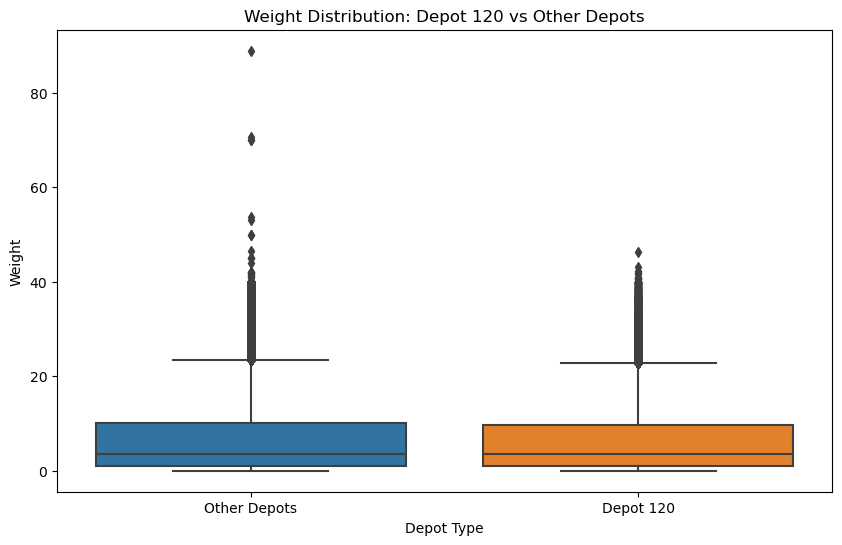

In [28]:
# Plot boxplot for 'WEIGHT'
plt.figure(figsize=(10, 6))
sns.boxplot(x='DEPOT_120', y='WEIGHT', data=df_unique)
plt.xticks(ticks=[0, 1], labels=['Other Depots', 'Depot 120'])
plt.title('Weight Distribution: Depot 120 vs Other Depots')
plt.xlabel('Depot Type')
plt.ylabel('Weight')
plt.show()

No apparent difference in weights between Depot 120 and other depots. 

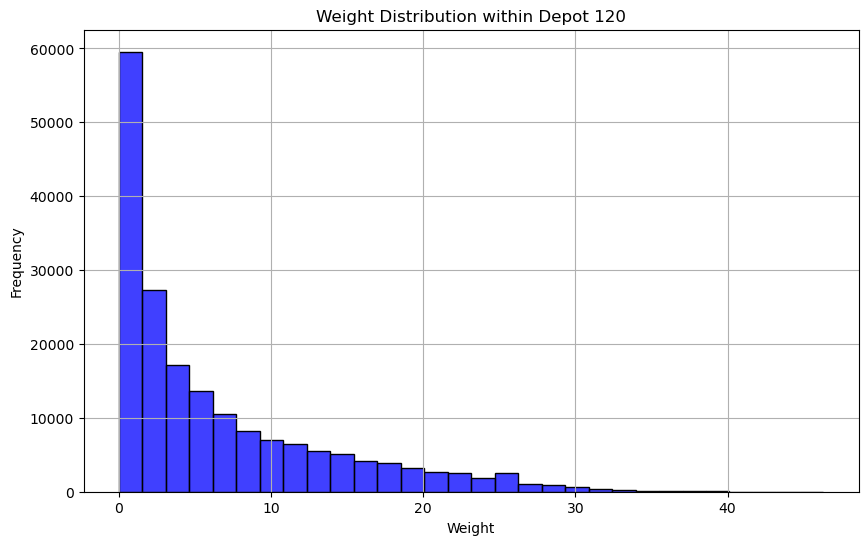

In [60]:
# Plot histogram for 'WEIGHT' within depot 120
plt.figure(figsize=(10, 6))
sns.histplot(depot_120['WEIGHT'].dropna(), bins=30, kde=False, color='blue')
plt.title('Weight Distribution within Depot 120')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The distribution looks like the one of all depots so nothing to analyze further.

In [35]:
# Group by destination depot ID
mean_weights_by_depot = df_unique.groupby('DESTINATION_DEPOT_ID')['WEIGHT'].mean()
# Create a DataFrame for easier handling and comparison
mean_weights_df = pd.DataFrame(mean_weights_by_depot).reset_index()
mean_weights_df.columns = ['Depot_ID', 'Mean_Weight']
# Set option to display all rows
pd.set_option('display.max_rows', None)
# Print results
print("Mean Weight by Depot:")
print(mean_weights_df)


Mean Weight by Depot:
    Depot_ID  Mean_Weight
0          1     4.620000
1        100     6.638525
2        110     6.304271
3        120     6.483262
4        130     6.686827
5        140     6.867909
6        150     6.281420
7        160     6.091799
8        170     8.373489
9        180     6.403572
10       190     6.525767
11       200     6.424574
12       210     6.527904
13       220     6.380829
14       230     6.628337
15       250     6.102117
16       260     6.560241
17       270     6.538165
18       280     6.547417
19       290     6.423969
20       300     6.429053
21       330     6.632177
22       350     6.487106
23       360     6.724669
24       370     6.534696
25       400     6.341359
26       410     6.170367
27       420     6.618492
28       430     6.343580
29       440     6.639344
30       450     6.387035
31       460     7.306487
32       470     6.239728
33       480     6.247507
34       490     6.370320
35       500     6.321111
36       540    

We can see that all depots have mean weights between 6 and 7. What are the ones that have more?

In [38]:
# Filter depots where the mean weight is greater than 7
depots_above_threshold = mean_weights_df[mean_weights_df['Mean_Weight'] > 7]

# Display the results
print("Depots with Mean Weights Greater Than 7:")
print(depots_above_threshold)

Depots with Mean Weights Greater Than 7:
    Depot_ID  Mean_Weight
8        170     8.373489
31       460     7.306487
36       540     7.112916


Depot 170 seems to have higher mean weight than all the other depots. Let us check for an outlier. 

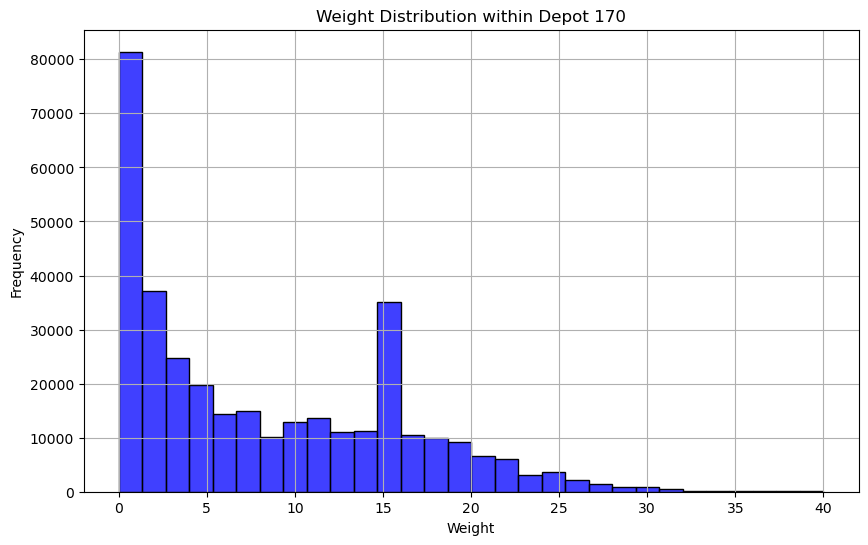

In [43]:
# Filter data for depot 170
depot_170 = df_unique[df_unique['DESTINATION_DEPOT_ID'] == 170]

# Plot histogram for 'WEIGHT' within depot 170
plt.figure(figsize=(10, 6))
sns.histplot(depot_170['WEIGHT'].dropna(), bins=30, kde=False, color='blue')
plt.title('Weight Distribution within Depot 170')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

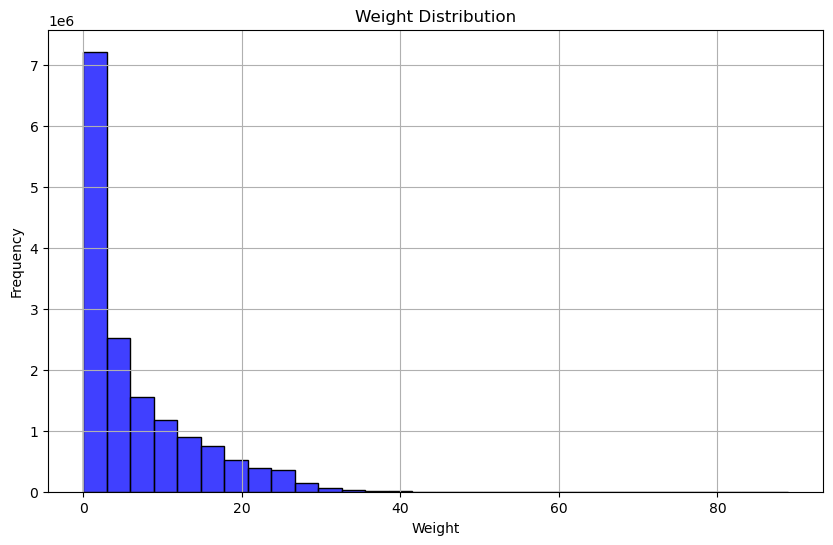

In [52]:
# Plot histogram for 'WEIGHT'
plt.figure(figsize=(10, 6))
sns.histplot(df_unique['WEIGHT'].dropna(), bins=30, kde=False, color='blue')
plt.title('Weight Distribution')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

We see that depot 170 and all the other depots have similar weight distributions. Depot 170 seems to have more units with weight 15. Are those the tires? Let us compare!

In [63]:
# Filter data for depot 17
depot_170 = df_unique[df_unique['DESTINATION_DEPOT_ID'] == 170]
# Count the number of observations with weight 15 in depot 170
count_weight_15_depot_170 = (depot_170['WEIGHT'] == 15).sum()
# Print the result
print(f"Number of observations with weight 15 in Depot 170: {count_weight_15_depot_170}")

# Filter data for all other depots except depot 170
other_depots = df_unique[df_unique['DESTINATION_DEPOT_ID'] != 170]
# Count the number of observations with weight 15 for each depot
count_weight_15_other_depots = other_depots.groupby('DESTINATION_DEPOT_ID')['WEIGHT'].apply(lambda x: (x == 15).sum())
# Calculate the average number of observations with weight 15 across other depots
average_count_weight_15_other_depots = count_weight_15_other_depots.mean()
# Print the result
print(f"Average number of observations with weight 15 in other depots: {average_count_weight_15_other_depots}")



Number of observations with weight 15 in Depot 170: 12766
Average number of observations with weight 15 in other depots: 1123.485294117647


Depot 170 has a lot more parcels with weight 15 that all the other depots.
### Depot 170 probably has the most tires.

In [50]:
# Filter data for depot 170
depot_170 = df_unique[df_unique['DESTINATION_DEPOT_ID'] == 170]

# Filter data for all other depots
other_depots = df_unique[df_unique['DESTINATION_DEPOT_ID'] != 170]

# Calculate mean and max weights for depot 170
mean_weight_depot_170 = depot_170['WEIGHT'].mean()
max_weight_depot_170 = depot_170['WEIGHT'].max()

# Calculate mean and max weights for other depots
mean_weight_other_depots = other_depots['WEIGHT'].mean()
max_weight_other_depots = other_depots['WEIGHT'].max()

# Print results
print(f"Depot 170 - Mean Weight: {mean_weight_depot_170}")
print(f"Depot 170 - Max Weight: {max_weight_depot_170}")
print(f"Other Depots - Mean Weight: {mean_weight_other_depots}")
print(f"Other Depots - Max Weight: {max_weight_other_depots}")

Depot 170 - Mean Weight: 8.373489103677327
Depot 170 - Max Weight: 40.0
Other Depots - Mean Weight: 6.448793856931292
Other Depots - Max Weight: 88.9


In [40]:
# Filter depots where the mean weight is less than 6
depots_below_threshold = mean_weights_df[mean_weights_df['Mean_Weight'] < 6]

# Display the results
print("Depots with Mean Weights Less Than 6:")
print(depots_below_threshold)

Depots with Mean Weights Less Than 6:
   Depot_ID  Mean_Weight
0         1         4.62


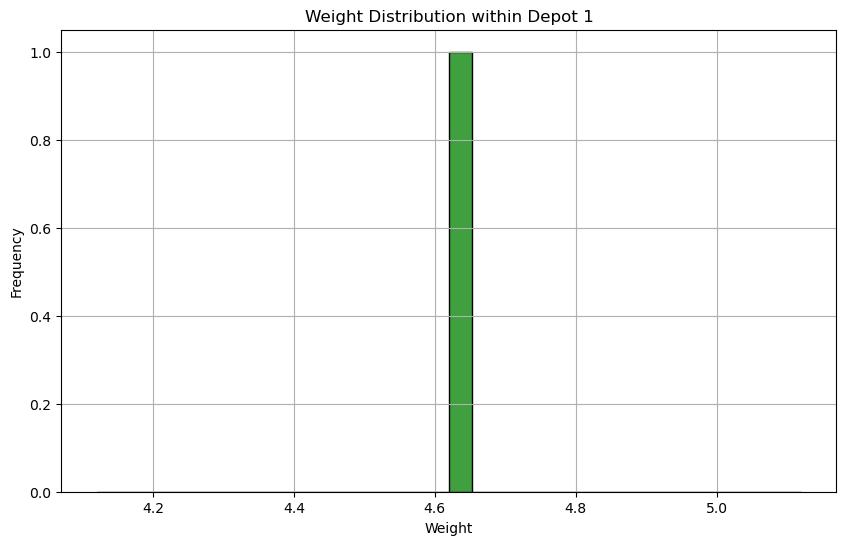

In [45]:
# Filter data for depot 1
depot_1 = df_unique[df_unique['DESTINATION_DEPOT_ID'] == 1]

# Plot histogram for 'WEIGHT' within depot 1
plt.figure(figsize=(10, 6))
sns.histplot(depot_1['WEIGHT'].dropna(), bins=30, kde=False, color='green')
plt.title('Weight Distribution within Depot 1')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [47]:
# Count the number of rows where DESTINATION_DEPOT_ID is 1
count_rows_depot_1 = len(df_unique[df_unique['DESTINATION_DEPOT_ID'] == 1])

# Print the result
print(f"Number of rows with DESTINATION_DEPOT_ID equal to 1: {count_rows_depot_1}")

Number of rows with DESTINATION_DEPOT_ID equal to 1: 1


Depot 1 only has one parcel, that explains why its mean weight is lower than the others. 

# Volume 

In [67]:
# Group by 'PREVIOUS_DEPOT_ID' and calculate mean volume for each depot
mean_volume_by_depot = df_unique.groupby('DESTINATION_DEPOT_ID')['VOLUME'].mean()

# Convert the Series to a DataFrame for easier viewing
mean_volume_df = mean_volume_by_depot.reset_index()
mean_volume_df.columns = ['Depot_ID', 'Mean_Volume']

# Print the results
print("Mean Volume for Each Depot:")
print(mean_volume_df)

Mean Volume for Each Depot:
    Depot_ID  Mean_Volume
0          1     4.840000
1        100     8.223769
2        110     8.077363
3        120    46.420761
4        130     8.144145
5        140     7.846031
6        150     7.415877
7        160     7.777746
8        170     8.960299
9        180     7.668728
10       190     7.841757
11       200     8.118787
12       210     8.135753
13       220     7.868210
14       230     7.972070
15       250     7.742791
16       260     8.004798
17       270     7.743962
18       280     8.242639
19       290     7.831274
20       300     7.092010
21       330     8.098256
22       350     7.661219
23       360     8.190758
24       370     7.777228
25       400     7.973791
26       410     7.538616
27       420     8.169979
28       430     7.706149
29       440     8.073298
30       450     7.800327
31       460     8.392579
32       470     7.532869
33       480     7.415744
34       490     8.048579
35       500     7.927511
36       5

Again we see that volumes are between 7 and 9. 

In [73]:
# Filter depots with mean volume greater than 9
depots_high_volume = mean_volume_df[mean_volume_df['Mean_Volume'] > 9]

# Filter depots with mean volume less than 7
depots_low_volume = mean_volume_df[mean_volume_df['Mean_Volume'] < 7]

# Print the results
print("Depots with Mean Volume Greater Than 9:")
print(depots_high_volume)

print("\nDepots with Mean Volume Less Than 7:")
print(depots_low_volume)

Depots with Mean Volume Greater Than 9:
    Depot_ID  Mean_Volume
3        120    46.420761
39       600     9.672162

Depots with Mean Volume Less Than 7:
   Depot_ID  Mean_Volume
0         1         4.84


Again depot 1 has the lowest volume because it only has 1 parcel. 
Depot 600 and depot 120 have volumes higher than 9. 

In [89]:
# Find the row with the highest volume
row_highest_volume = df_unique.loc[df_unique['VOLUME'].idxmax()]

# Retrieve the DESTINATION_DEPOT_ID for that row
destination_depot_id_highest_volume = row_highest_volume['DESTINATION_DEPOT_ID']
highest_volume = row_highest_volume['VOLUME']

# Print the results
print(f"Row with the highest volume has VOLUME: {highest_volume}")
print(f"DESTINATION_DEPOT_ID for this row is: {destination_depot_id_highest_volume}")

Row with the highest volume has VOLUME: 239400.0
DESTINATION_DEPOT_ID for this row is: 120


In [92]:
# Find the index of the row with the highest volume
index_highest_volume = df_unique['VOLUME'].idxmax()

# Drop the row with the highest volume
df_unique_dropped = df_unique.drop(index_highest_volume)

# Filter data for depot 120 from the updated DataFrame
depot_120_dropped = df_unique_dropped[df_unique_dropped['DESTINATION_DEPOT_ID'] == 120]

# Calculate the mean volume for depot 120
mean_volume_depot_120_dropped = depot_120_dropped['VOLUME'].mean()

# Print the updated mean volume
print(f"Updated mean volume for Depot 120 after dropping the highest volume row: {mean_volume_depot_120_dropped:.2f}")


Updated mean volume for Depot 120 after dropping the highest volume row: 6.40


The highest volume is found at depot 120, which might explain why the mean is higher. If we drop it, the means become quite similar, even lower! 

In [84]:
# Filter data for depot 120
depot_120 = df_unique[df_unique['DESTINATION_DEPOT_ID'] == 120]

# Filter data for all other depots
other_depots = df_unique[df_unique['DESTINATION_DEPOT_ID'] != 120]
# Count missing values in 'VOLUME' for depot 120
missing_values_depot_120 = depot_120['VOLUME'].isna().sum()

# Count missing values in 'VOLUME' for other depots
missing_values_other_depots = other_depots['VOLUME'].isna().sum()

# Print results
print(f"Number of missing values in 'VOLUME' for Depot 120: {missing_values_depot_120}")
print(f"Number of missing values in 'VOLUME' for Other Depots: {missing_values_other_depots}")

Number of missing values in 'VOLUME' for Depot 120: 178824
Number of missing values in 'VOLUME' for Other Depots: 6520999


In [86]:
# Calculate the total number of observations for depot 120
total_observations_depot_120 = len(depot_120)

# Calculate the total number of observations for other depots
total_observations_other_depots = len(other_depots)

# Count missing values in 'VOLUME' for depot 120
missing_values_depot_120 = depot_120['VOLUME'].isna().sum()

# Count missing values in 'VOLUME' for other depots
missing_values_other_depots = other_depots['VOLUME'].isna().sum()

# Calculate the percentage of missing values for depot 120
percentage_missing_depot_120 = (missing_values_depot_120 / total_observations_depot_120) * 100

# Calculate the percentage of missing values for other depots
percentage_missing_other_depots = (missing_values_other_depots / total_observations_other_depots) * 100

# Print results
print(f"Percentage of missing values in 'VOLUME' for Depot 120: {percentage_missing_depot_120:.2f}%")
print(f"Percentage of missing values in 'VOLUME' for Other Depots: {percentage_missing_other_depots:.2f}%")

Percentage of missing values in 'VOLUME' for Depot 120: 96.76%
Percentage of missing values in 'VOLUME' for Other Depots: 42.17%


We see that MOST volumes are missing at Depot 120, in comparison to other depots where it is less than half.
### But this might be very important to highlight because maybe what makes it hard to find volumes for those parcels IS exactly what differentiates depots 120.

# Small

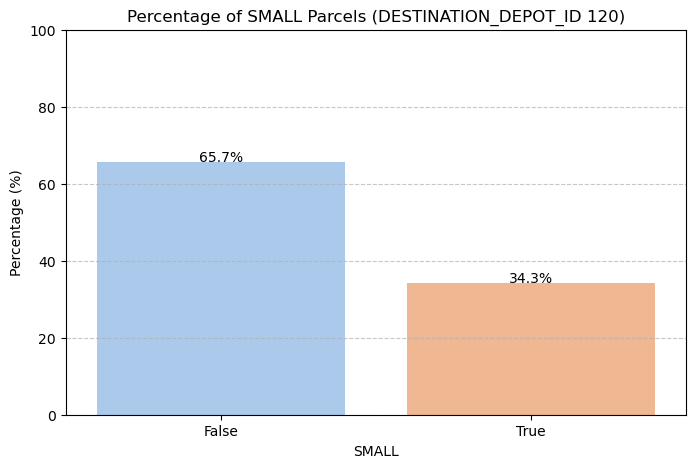

In [227]:
# Filter data for DESTINATION_DEPOT_ID 120
filtered_data = df_unique[df_unique['DESTINATION_DEPOT_ID'] == 120]

# Calculate the counts of True and False in the SMALL column as percentages
small_counts = filtered_data['SMALL'].value_counts(normalize=True).reset_index()
small_counts.columns = ['SMALL', 'Percentage']

# Convert the percentage to a range from 0 to 100
small_counts['Percentage'] *= 100

# Plot the data
plt.figure(figsize=(8, 5))
sns.barplot(x='SMALL', y='Percentage', data=small_counts, palette='pastel')
plt.title('Percentage of SMALL Parcels (DESTINATION_DEPOT_ID 120)')
plt.xlabel('SMALL')
plt.ylabel('Percentage (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([0, 1], ['False', 'True'])  # Label the x-axis correctly
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100

# Add percentage labels on top of the bars
for index, row in small_counts.iterrows():
    plt.text(index, row['Percentage'], f"{row['Percentage']:.1f}%", color='black', ha="center")

plt.show()

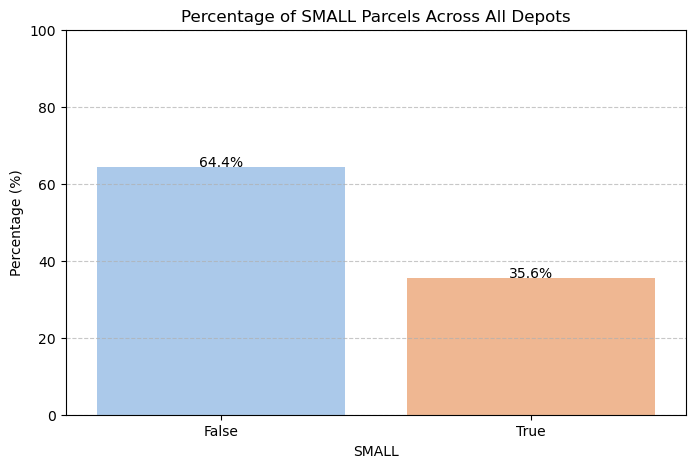

In [229]:
# Calculate the counts of True and False in the SMALL column as percentages
small_counts_all = df_unique['SMALL'].value_counts(normalize=True).reset_index()
small_counts_all.columns = ['SMALL', 'Percentage']

# Convert the percentage to a range from 0 to 100
small_counts_all['Percentage'] *= 100

# Plot the data
plt.figure(figsize=(8, 5))
sns.barplot(x='SMALL', y='Percentage', data=small_counts_all, palette='pastel')
plt.title('Percentage of SMALL Parcels Across All Depots')
plt.xlabel('SMALL')
plt.ylabel('Percentage (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([0, 1], ['False', 'True'])  # Label the x-axis correctly
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100

# Add percentage labels on top of the bars
for index, row in small_counts_all.iterrows():
    plt.text(index, row['Percentage'], f"{row['Percentage']:.1f}%", color='black', ha="center")

plt.show()

Similar percentages of small and not small parcels in depot 120 and other depots. 

In [239]:
# Filter data for DESTINATION_DEPOT_ID 120
data_depot_120 = df_unique[df_unique['DESTINATION_DEPOT_ID'] == 120]
data_other_depots = df_unique[df_unique['DESTINATION_DEPOT_ID'] != 120]

# Calculate total number of rows for each group
total_120 = data_depot_120.shape[0]
total_other = data_other_depots.shape[0]

# Calculate number of missing values in the SMALL column for each group
missing_120 = data_depot_120['SMALL'].isna().sum()
missing_other = data_other_depots['SMALL'].isna().sum()

# Calculate the percentage of missing values
percentage_missing_120 = (missing_120 / total_120) * 100
percentage_missing_other = (missing_other / total_other) * 100

print(f"Percentage of missing SMALL labels for depot 120: {percentage_missing_120:.2f}%")
print(f"Percentage of missing SMALL labels for other depots: {percentage_missing_other:.2f}%")

Percentage of missing SMALL labels for depot 120: 0.00%
Percentage of missing SMALL labels for other depots: 0.00%


We do not have to worry about missing labels. 

# Hazardous

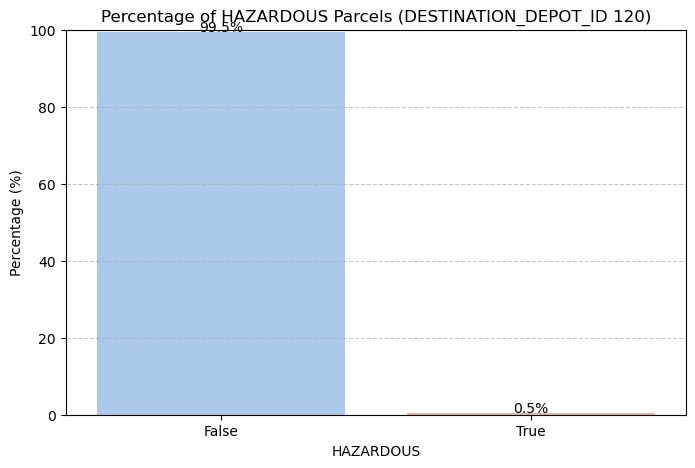

In [233]:
# Filter data for DESTINATION_DEPOT_ID 120
filtered_data = df_unique[df_unique['DESTINATION_DEPOT_ID'] == 120]

# Calculate the counts of True and False in the HAZARDOUS column as percentages
hazardous_counts_120 = filtered_data['HAZARDOUS'].value_counts(normalize=True).reset_index()
hazardous_counts_120.columns = ['HAZARDOUS', 'Percentage']

# Convert the percentage to a range from 0 to 100
hazardous_counts_120['Percentage'] *= 100

# Plot the data
plt.figure(figsize=(8, 5))
sns.barplot(x='HAZARDOUS', y='Percentage', data=hazardous_counts_120, palette='pastel')
plt.title('Percentage of HAZARDOUS Parcels (DESTINATION_DEPOT_ID 120)')
plt.xlabel('HAZARDOUS')
plt.ylabel('Percentage (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([0, 1], ['False', 'True'])  # Label the x-axis correctly
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100

# Add percentage labels on top of the bars
for index, row in hazardous_counts_120.iterrows():
    plt.text(index, row['Percentage'], f"{row['Percentage']:.1f}%", color='black', ha="center")

plt.show()

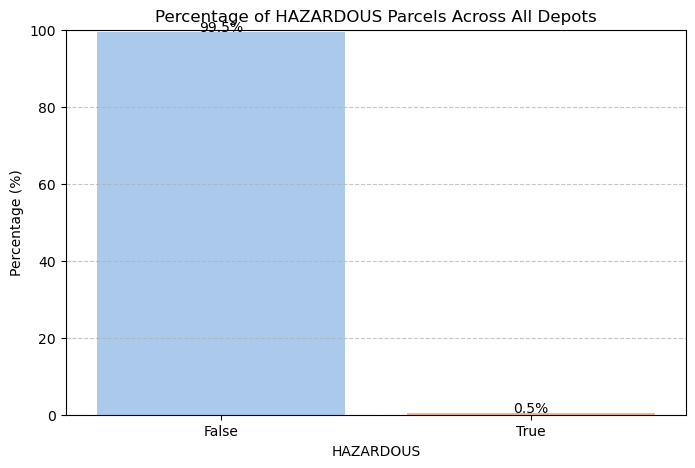

In [236]:
# Calculate the counts of True and False in the HAZARDOUS column as percentages for all depots
hazardous_counts_all = df_unique['HAZARDOUS'].value_counts(normalize=True).reset_index()
hazardous_counts_all.columns = ['HAZARDOUS', 'Percentage']

# Convert the percentage to a range from 0 to 100
hazardous_counts_all['Percentage'] *= 100

# Plot the data
plt.figure(figsize=(8, 5))
sns.barplot(x='HAZARDOUS', y='Percentage', data=hazardous_counts_all, palette='pastel')
plt.title('Percentage of HAZARDOUS Parcels Across All Depots')
plt.xlabel('HAZARDOUS')
plt.ylabel('Percentage (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([0, 1], ['False', 'True'])  # Label the x-axis correctly
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100

# Add percentage labels on top of the bars
for index, row in hazardous_counts_all.iterrows():
    plt.text(index, row['Percentage'], f"{row['Percentage']:.1f}%", color='black', ha="center")

plt.show()

Depot 120 has the same percentages of hazardous and non hazardous parcels as all depots. 

In [243]:
# Filter data for DESTINATION_DEPOT_ID 120
data_depot_120 = df_unique[df_unique['DESTINATION_DEPOT_ID'] == 120]
data_other_depots = df_unique[df_unique['DESTINATION_DEPOT_ID'] != 120]

# Calculate total number of rows for each group
total_120 = data_depot_120.shape[0]
total_other = data_other_depots.shape[0]

# Calculate number of missing values in the HAZARDOUS column for each group
missing_120 = data_depot_120['HAZARDOUS'].isna().sum()
missing_other = data_other_depots['HAZARDOUS'].isna().sum()

# Calculate the percentage of missing values
percentage_missing_120 = (missing_120 / total_120) * 100
percentage_missing_other = (missing_other / total_other) * 100

print(f"Percentage of missing HAZARDOUS labels for depot 120: {percentage_missing_120:.2f}%")
print(f"Percentage of missing HAZARDOUS labels for other depots: {percentage_missing_other:.2f}%")

Percentage of missing HAZARDOUS labels for depot 120: 0.00%
Percentage of missing HAZARDOUS labels for other depots: 0.00%


Both depot 120 and all the other depots have no missing cells for the hazardous label.

# SCAN Depot ID

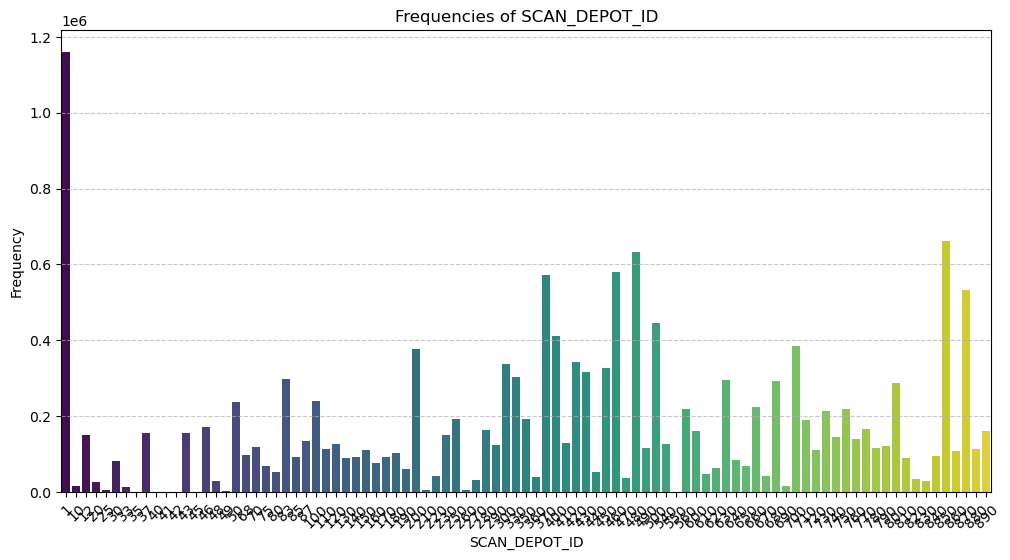

In [103]:
# Count the frequencies of each PREVIOUS_DEPOT_ID
frequency_previous_depot = df_unique['SCAN_DEPOT_ID'].value_counts()

# Convert to DataFrame for easier plotting
frequency_previous_depot_df = frequency_previous_depot.reset_index()
frequency_previous_depot_df.columns = ['SCAN_DEPOT_ID', 'Frequency']

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(x='SCAN_DEPOT_ID', y='Frequency', data=frequency_previous_depot_df, palette='viridis')
plt.title('Frequencies of SCAN_DEPOT_ID')
plt.xlabel('SCAN_DEPOT_ID')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

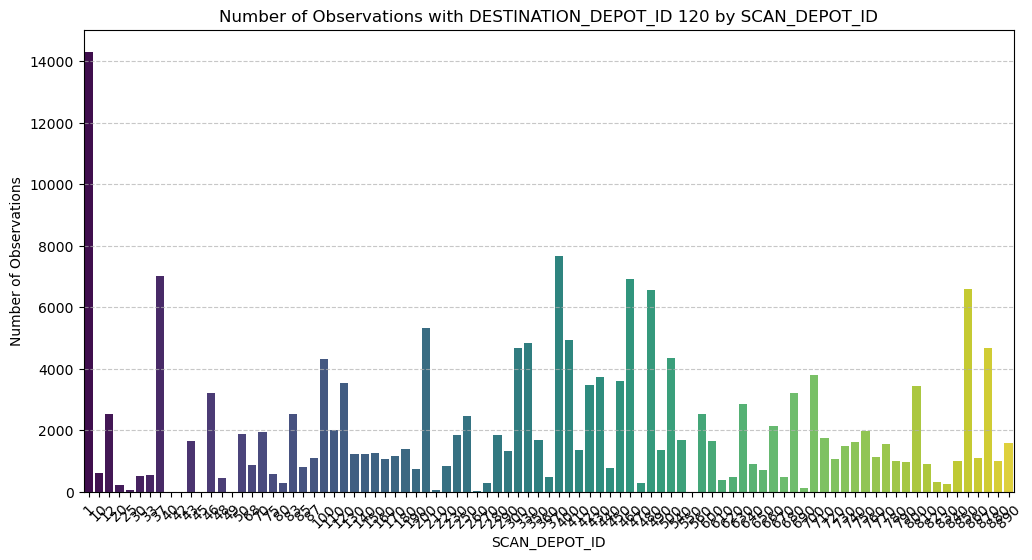

In [105]:
# Filter data for DESTINATION_DEPOT_ID 120
depot_120 = df_unique[df_unique['DESTINATION_DEPOT_ID'] == 120]

# Count the number of observations for each PREVIOUS_DEPOT_ID
count_previous_depot = depot_120['SCAN_DEPOT_ID'].value_counts()

# Convert to DataFrame for easier plotting
count_previous_depot_df = count_previous_depot.reset_index()
count_previous_depot_df.columns = ['SCAN_DEPOT_ID', 'Count']

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(x='SCAN_DEPOT_ID', y='Count', data=count_previous_depot_df, palette='viridis')
plt.title('Number of Observations with DESTINATION_DEPOT_ID 120 by SCAN_DEPOT_ID')
plt.xlabel('SCAN_DEPOT_ID')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Most of the parcels coming to 120 come from depot 1 (over 14k) and then we have 4 other depots with over 6k parcels: depot 37, 370, 460, 480 and 850

In [138]:
# Filter data for DESTINATION_DEPOT_ID 120
depot_120 = df_unique[df_unique['DESTINATION_DEPOT_ID'] == 120]

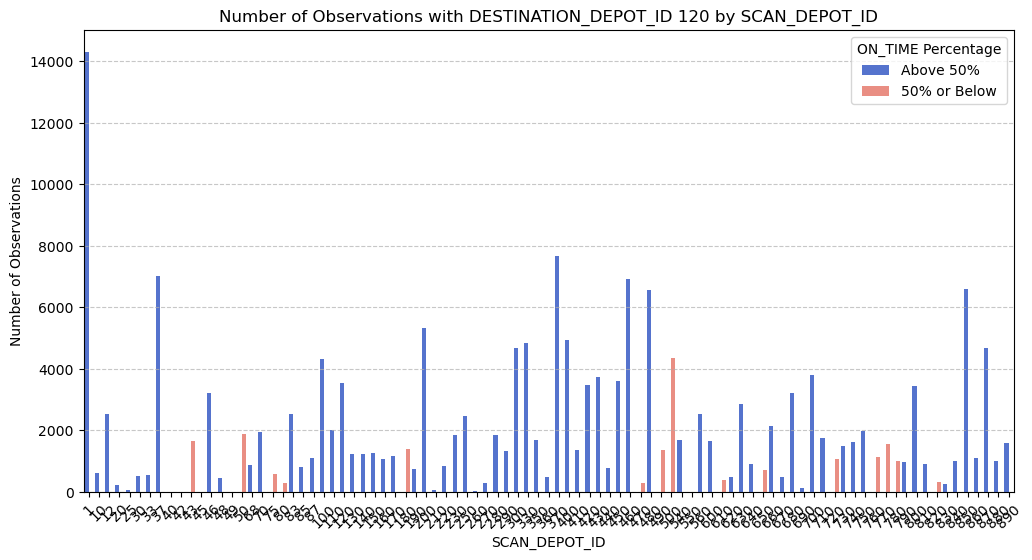

In [140]:
# Calculate the percentage of ON_TIME=True for each SCAN_DEPOT_ID
percentage_on_time = depot_120.groupby('SCAN_DEPOT_ID')['ON_TIME'].agg(lambda x: (x.sum() / len(x)) * 100).reset_index()
percentage_on_time.columns = ['SCAN_DEPOT_ID', 'Percentage_ON_TIME']

# Classify each SCAN_DEPOT_ID based on the percentage
percentage_on_time['Category'] = percentage_on_time['Percentage_ON_TIME'].apply(lambda x: 'Above 50%' if x > 50 else '50% or Below')

# Count the number of observations for each SCAN_DEPOT_ID
count_previous_depot = depot_120['SCAN_DEPOT_ID'].value_counts().reset_index()
count_previous_depot.columns = ['SCAN_DEPOT_ID', 'Count']

# Merge the count data with the percentage data
plot_data = pd.merge(count_previous_depot, percentage_on_time, on='SCAN_DEPOT_ID')

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(x='SCAN_DEPOT_ID', y='Count', hue='Category', data=plot_data, palette={'Above 50%': 'royalblue', '50% or Below': 'salmon'})
plt.title('Number of Observations with DESTINATION_DEPOT_ID 120 by SCAN_DEPOT_ID')
plt.xlabel('SCAN_DEPOT_ID')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.legend(title='ON_TIME Percentage')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We notice that all the MAIN depots have true percentages on on time deliveries of higher than 50%. Depot 500 has over 4k parcels and an on_time percentage lower then 50%. What if we raise the bar? At 75%

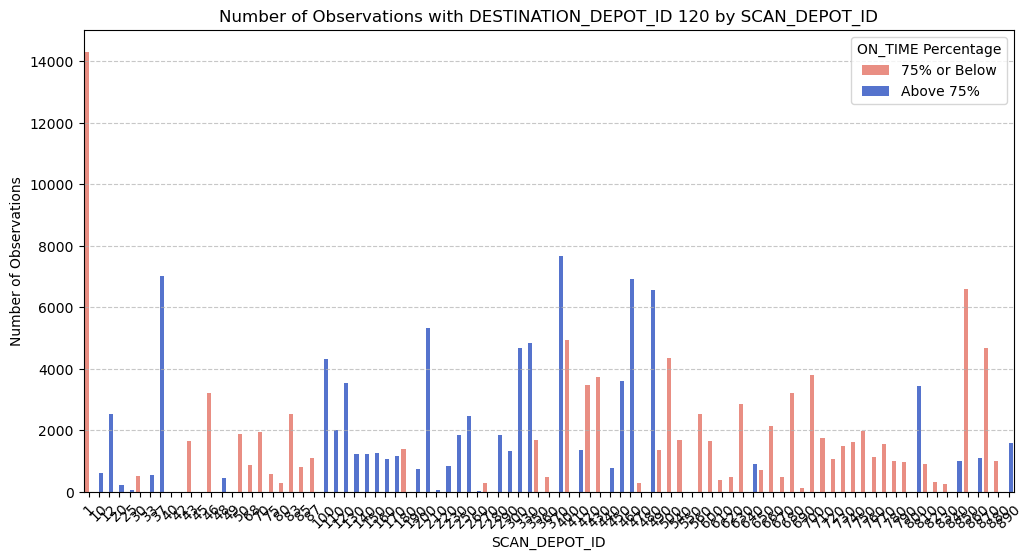

In [158]:
# Classify each SCAN_DEPOT_ID based on the percentage
percentage_on_time['Category'] = percentage_on_time['Percentage_ON_TIME'].apply(lambda x: 'Above 75%' if x > 75 else '75% or Below')

# Count the number of observations for each SCAN_DEPOT_ID
count_previous_depot = depot_120['SCAN_DEPOT_ID'].value_counts().reset_index()
count_previous_depot.columns = ['SCAN_DEPOT_ID', 'Count']

# Merge the count data with the percentage data
plot_data = pd.merge(count_previous_depot, percentage_on_time, on='SCAN_DEPOT_ID')

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(x='SCAN_DEPOT_ID', y='Count', hue='Category', data=plot_data, palette={'Above 75%': 'royalblue', '75% or Below': 'salmon'})
plt.title('Number of Observations with DESTINATION_DEPOT_ID 120 by SCAN_DEPOT_ID')
plt.xlabel('SCAN_DEPOT_ID')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.legend(title='ON_TIME Percentage')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

At 75%, depot 1 as wel as depot 850 have less than 75% true percentages of on time deliveries. Since depot 1 is the largest, we delve deeper in the details.  

At the same time, depot 1 has the LARGEST number of deliveries so it is more likely to have less on_time deliveries. We should also look at depot 850.

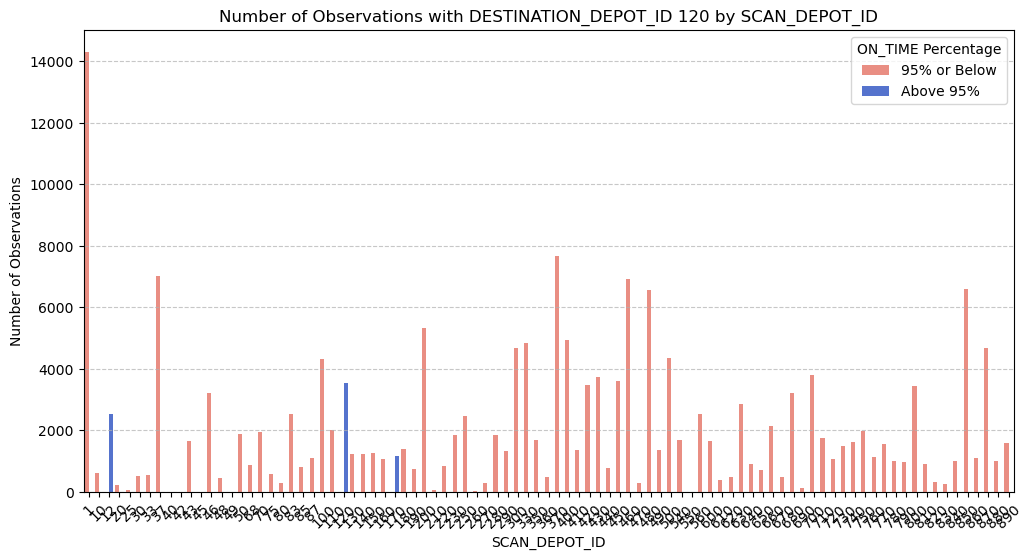

In [164]:
# Classify each SCAN_DEPOT_ID based on the percentage
percentage_on_time['Category'] = percentage_on_time['Percentage_ON_TIME'].apply(lambda x: 'Above 95%' if x > 95 else '95% or Below')

# Count the number of observations for each SCAN_DEPOT_ID
count_previous_depot = depot_120['SCAN_DEPOT_ID'].value_counts().reset_index()
count_previous_depot.columns = ['SCAN_DEPOT_ID', 'Count']

# Merge the count data with the percentage data
plot_data = pd.merge(count_previous_depot, percentage_on_time, on='SCAN_DEPOT_ID')

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(x='SCAN_DEPOT_ID', y='Count', hue='Category', data=plot_data, palette={'Above 95%': 'royalblue', '95% or Below': 'salmon'})
plt.title('Number of Observations with DESTINATION_DEPOT_ID 120 by SCAN_DEPOT_ID')
plt.xlabel('SCAN_DEPOT_ID')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.legend(title='ON_TIME Percentage')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We then try to find the 'best' depot, or the scan_depot that delivers on time more than 95% of the time and we use depot 110.

### DEPOT 1 Weight distribution

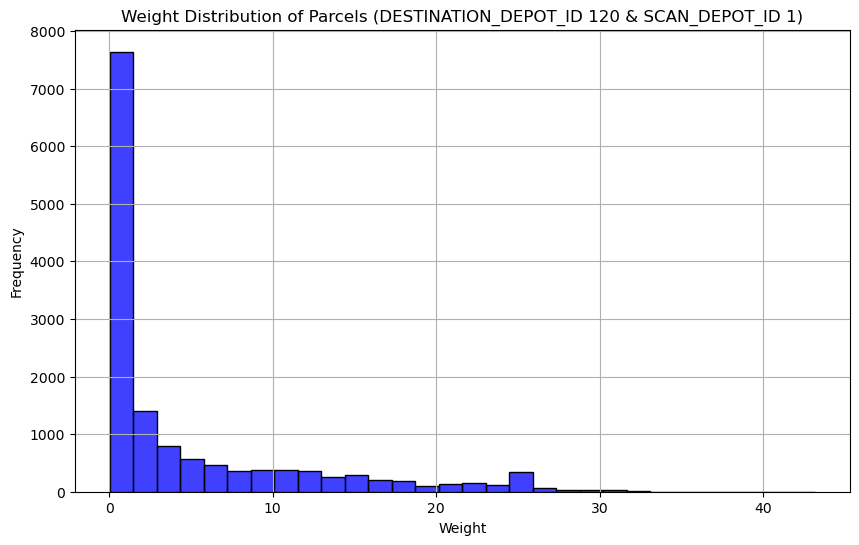

In [160]:
# Filter data for DESTINATION_DEPOT_ID 120 and SCAN_DEPOT_ID 1
filtered_data = df_unique[(df_unique['DESTINATION_DEPOT_ID'] == 120) & (df_unique['SCAN_DEPOT_ID'] == 1)]

# Plot histogram for 'WEIGHT' within the filtered dataset
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['WEIGHT'].dropna(), bins=30, kde=False, color='blue')
plt.title('Weight Distribution of Parcels (DESTINATION_DEPOT_ID 120 & SCAN_DEPOT_ID 1)')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Depot 850 Weight distribution

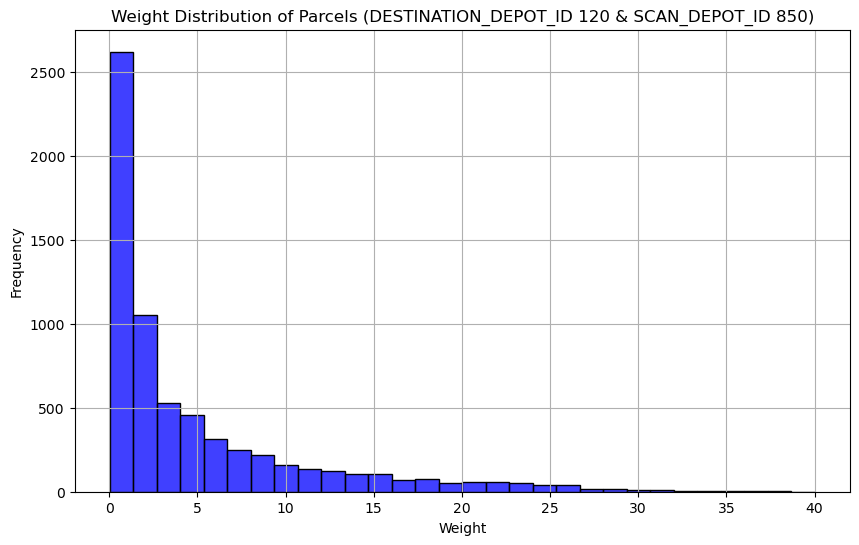

In [190]:
# Filter data for DESTINATION_DEPOT_ID 120 and SCAN_DEPOT_ID 1
filtered_data = df_unique[(df_unique['DESTINATION_DEPOT_ID'] == 120) & (df_unique['SCAN_DEPOT_ID'] == 850)]

# Plot histogram for 'WEIGHT' within the filtered dataset
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['WEIGHT'].dropna(), bins=30, kde=False, color='blue')
plt.title('Weight Distribution of Parcels (DESTINATION_DEPOT_ID 120 & SCAN_DEPOT_ID 850)')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### Depot 110 weight distribution

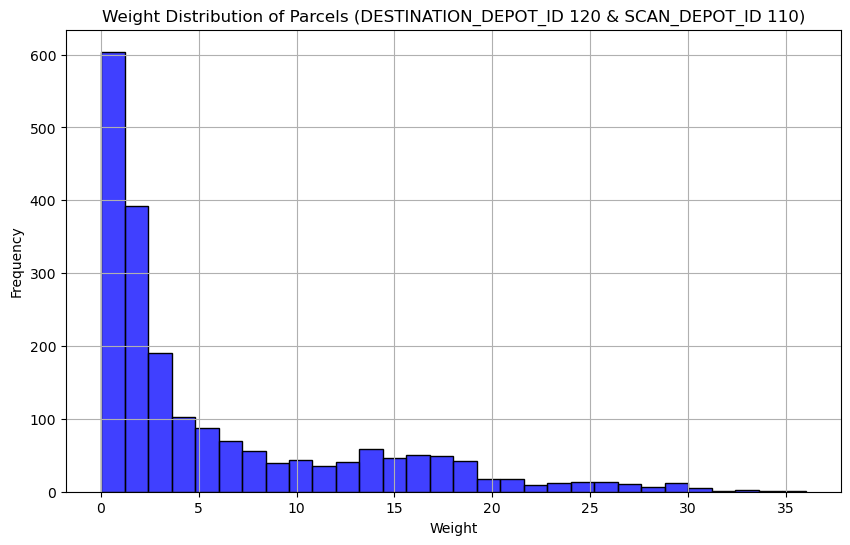

In [166]:
# Filter data for DESTINATION_DEPOT_ID 120 and SCAN_DEPOT_ID 110
filtered_data = df_unique[(df_unique['DESTINATION_DEPOT_ID'] == 120) & (df_unique['SCAN_DEPOT_ID'] == 110)]

# Plot histogram for 'WEIGHT' within the filtered dataset
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['WEIGHT'].dropna(), bins=30, kde=False, color='blue')
plt.title('Weight Distribution of Parcels (DESTINATION_DEPOT_ID 120 & SCAN_DEPOT_ID 110)')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Very similar distributions, nothing to highlight here. 

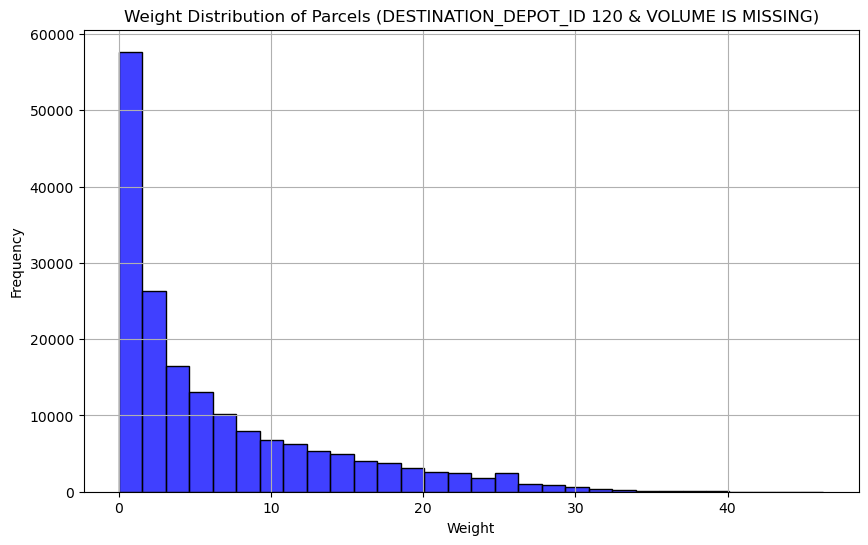

In [297]:
# Filter data for DESTINATION_DEPOT_ID 120 and Volume is missing
filtered_data = df_unique[(df_unique['DESTINATION_DEPOT_ID'] == 120) & (df_unique['VOLUME'].isna())]

# Plot histogram for 'WEIGHT' within the filtered dataset
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['WEIGHT'].dropna(), bins=30, kde=False, color='blue')
plt.title('Weight Distribution of Parcels (DESTINATION_DEPOT_ID 120 & VOLUME IS MISSING)')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Analysis of Volume for depot 1, 850 and 110

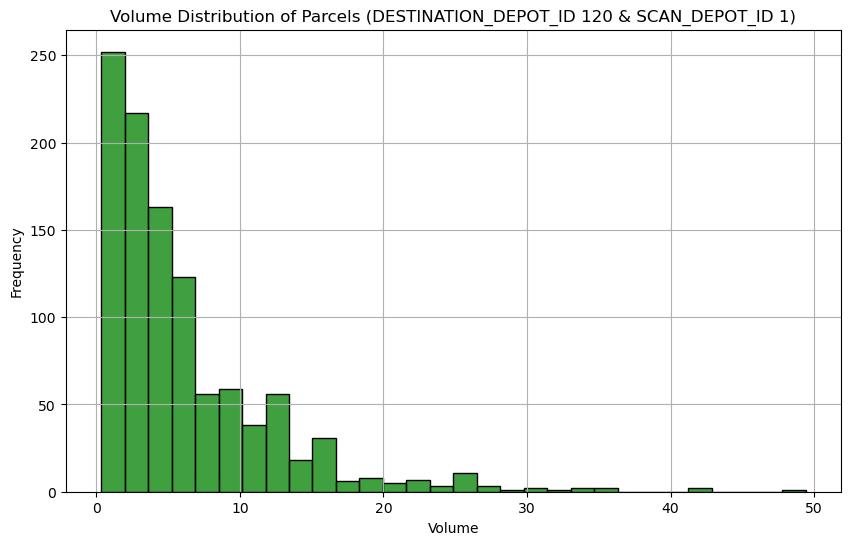

In [168]:
# Filter data for DESTINATION_DEPOT_ID 120 and SCAN_DEPOT_ID 1
filtered_data = df_unique[(df_unique['DESTINATION_DEPOT_ID'] == 120) & (df_unique['SCAN_DEPOT_ID'] == 1)]

# Plot histogram for 'VOLUME' within the filtered dataset
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['VOLUME'].dropna(), bins=30, kde=False, color='green')
plt.title('Volume Distribution of Parcels (DESTINATION_DEPOT_ID 120 & SCAN_DEPOT_ID 1)')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

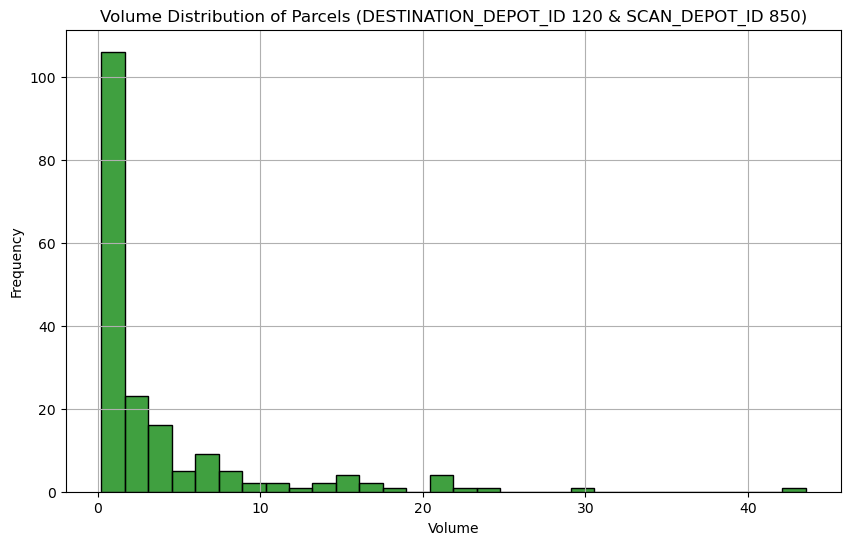

In [192]:
# Filter data for DESTINATION_DEPOT_ID 120 and SCAN_DEPOT_ID 850
filtered_data = df_unique[(df_unique['DESTINATION_DEPOT_ID'] == 120) & (df_unique['SCAN_DEPOT_ID'] == 850)]

# Plot histogram for 'VOLUME' within the filtered dataset
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['VOLUME'].dropna(), bins=30, kde=False, color='green')
plt.title('Volume Distribution of Parcels (DESTINATION_DEPOT_ID 120 & SCAN_DEPOT_ID 850)')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

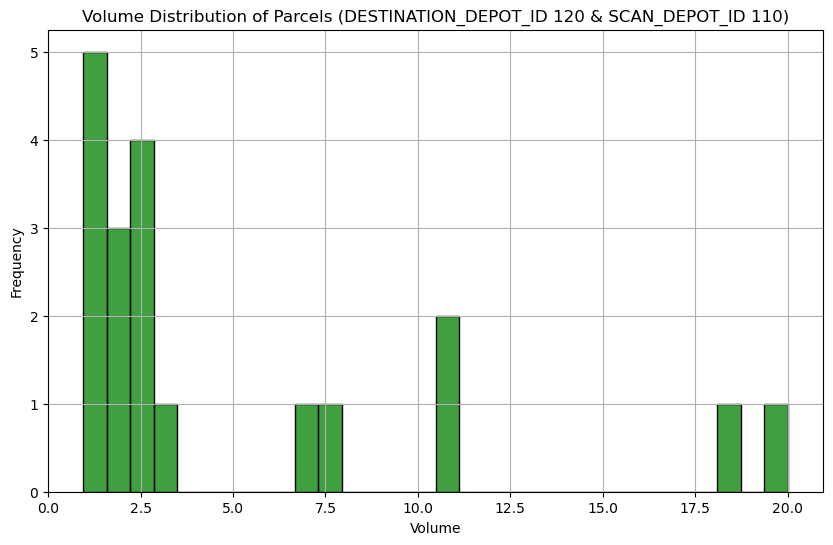

In [170]:
# Filter data for DESTINATION_DEPOT_ID 120 and SCAN_DEPOT_ID 110
filtered_data = df_unique[(df_unique['DESTINATION_DEPOT_ID'] == 120) & (df_unique['SCAN_DEPOT_ID'] == 110)]

# Plot histogram for 'VOLUME' within the filtered dataset
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['VOLUME'].dropna(), bins=30, kde=False, color='green')
plt.title('Volume Distribution of Parcels (DESTINATION_DEPOT_ID 120 & SCAN_DEPOT_ID 110)')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Nothing to highlight either on volumes.

### Analysis of Small for depot 1, 850 and 110

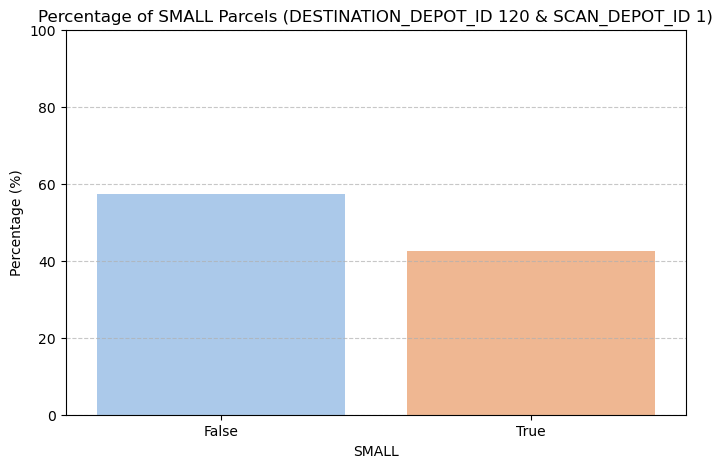

In [176]:
# Filter data for DESTINATION_DEPOT_ID 120 and SCAN_DEPOT_ID 1
filtered_data = df_unique[(df_unique['DESTINATION_DEPOT_ID'] == 120) & (df_unique['SCAN_DEPOT_ID'] == 1)]

# Calculate the counts of True and False in the SMALL column
small_counts = filtered_data['SMALL'].value_counts(normalize=True).reset_index()
small_counts.columns = ['SMALL', 'Percentage']

# Convert the percentage to a range from 0 to 100
small_counts['Percentage'] *= 100

# Plot the data
plt.figure(figsize=(8, 5))
sns.barplot(x='SMALL', y='Percentage', data=small_counts, palette='pastel')
plt.title('Percentage of SMALL Parcels (DESTINATION_DEPOT_ID 120 & SCAN_DEPOT_ID 1)')
plt.xlabel('SMALL')
plt.ylabel('Percentage (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([0, 1], ['False', 'True'])  # Label the x-axis correctly
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100
plt.show()

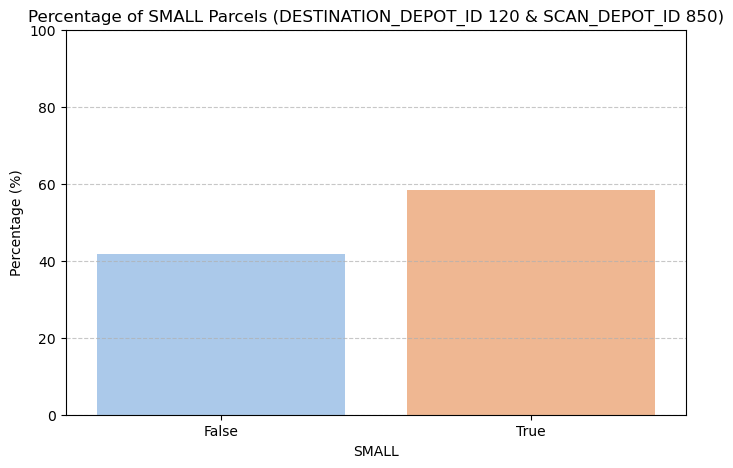

In [194]:
# Filter data for DESTINATION_DEPOT_ID 120 and SCAN_DEPOT_ID 850
filtered_data = df_unique[(df_unique['DESTINATION_DEPOT_ID'] == 120) & (df_unique['SCAN_DEPOT_ID'] == 850)]

# Calculate the counts of True and False in the SMALL column
small_counts = filtered_data['SMALL'].value_counts(normalize=True).reset_index()
small_counts.columns = ['SMALL', 'Percentage']

# Convert the percentage to a range from 0 to 100
small_counts['Percentage'] *= 100

# Plot the data
plt.figure(figsize=(8, 5))
sns.barplot(x='SMALL', y='Percentage', data=small_counts, palette='pastel')
plt.title('Percentage of SMALL Parcels (DESTINATION_DEPOT_ID 120 & SCAN_DEPOT_ID 850)')
plt.xlabel('SMALL')
plt.ylabel('Percentage (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([0, 1], ['False', 'True'])  # Label the x-axis correctly
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100
plt.show()

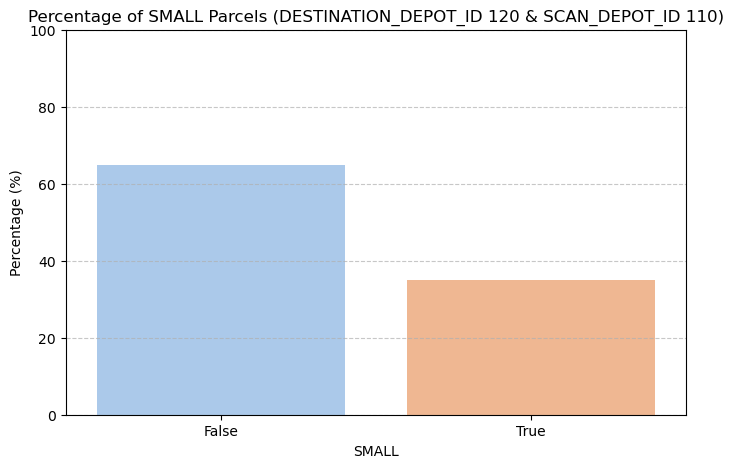

In [178]:
# Filter data for DESTINATION_DEPOT_ID 120 and SCAN_DEPOT_ID 110
filtered_data = df_unique[(df_unique['DESTINATION_DEPOT_ID'] == 120) & (df_unique['SCAN_DEPOT_ID'] == 110)]

# Calculate the counts of True and False in the SMALL column
small_counts = filtered_data['SMALL'].value_counts(normalize=True).reset_index()
small_counts.columns = ['SMALL', 'Percentage']

# Convert the percentage to a range from 0 to 100
small_counts['Percentage'] *= 100

# Plot the data
plt.figure(figsize=(8, 5))
sns.barplot(x='SMALL', y='Percentage', data=small_counts, palette='pastel')
plt.title('Percentage of SMALL Parcels (DESTINATION_DEPOT_ID 120 & SCAN_DEPOT_ID 110)')
plt.xlabel('SMALL')
plt.ylabel('Percentage (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([0, 1], ['False', 'True'])  # Label the x-axis correctly
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100
plt.show()

We see that for depot 1 and depot 850, which have worse on-time deliveries, there are more percentages of small parcels (>40%) compared to depot 110. So this might be important to look deeper in!

Looking at scan_depot_id 500 which has over 4k parcels and less than 50% on_time delivery percentage to see if there is indeed a trend. 

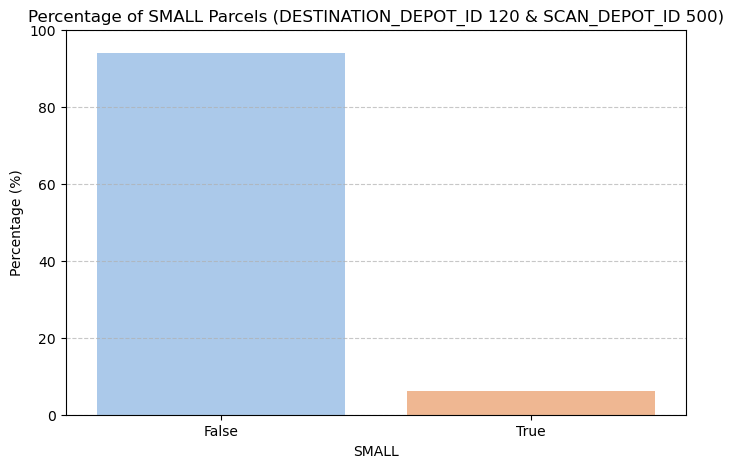

In [248]:
# Filter data for DESTINATION_DEPOT_ID 120 and SCAN_DEPOT_ID 500
filtered_data = df_unique[(df_unique['DESTINATION_DEPOT_ID'] == 120) & (df_unique['SCAN_DEPOT_ID'] == 500)]

# Calculate the counts of True and False in the SMALL column
small_counts = filtered_data['SMALL'].value_counts(normalize=True).reset_index()
small_counts.columns = ['SMALL', 'Percentage']

# Convert the percentage to a range from 0 to 100
small_counts['Percentage'] *= 100

# Plot the data
plt.figure(figsize=(8, 5))
sns.barplot(x='SMALL', y='Percentage', data=small_counts, palette='pastel')
plt.title('Percentage of SMALL Parcels (DESTINATION_DEPOT_ID 120 & SCAN_DEPOT_ID 500)')
plt.xlabel('SMALL')
plt.ylabel('Percentage (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([0, 1], ['False', 'True'])  # Label the x-axis correctly
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100
plt.show()

Depot 500 disproves the theory we had.

### Analysis of HAZARDOUS for depots 1, 850 and 110

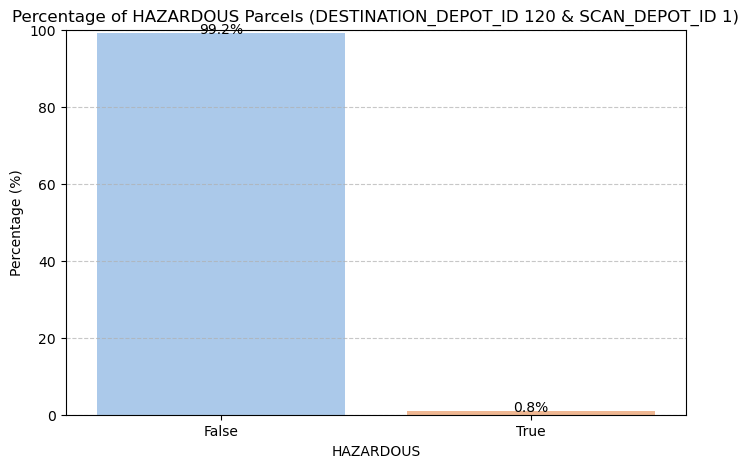

In [213]:
# Filter data for DESTINATION_DEPOT_ID 120 and SCAN_DEPOT_ID 1
filtered_data = df_unique[(df_unique['DESTINATION_DEPOT_ID'] == 120) & (df_unique['SCAN_DEPOT_ID'] == 1)]

# Calculate the counts of True and False in the SMALL column
hazardous_counts = filtered_data['HAZARDOUS'].value_counts(normalize=True).reset_index()
hazardous_counts.columns = ['HAZARDOUS', 'Percentage']

# Convert the percentage to a range from 0 to 100
hazardous_counts['Percentage'] *= 100

# Plot the data
plt.figure(figsize=(8, 5))
barplot = sns.barplot(x='HAZARDOUS', y='Percentage', data=hazardous_counts, palette='pastel')
plt.title('Percentage of HAZARDOUS Parcels (DESTINATION_DEPOT_ID 120 & SCAN_DEPOT_ID 1)')
plt.xlabel('HAZARDOUS')
plt.ylabel('Percentage (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([0, 1], ['False', 'True'])  # Label the x-axis correctly
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100

# Add percentage labels on top of the bars
for index, row in hazardous_counts.iterrows():
    barplot.text(row.name, row['Percentage'], f"{row['Percentage']:.1f}%", color='black', ha="center")

plt.show()

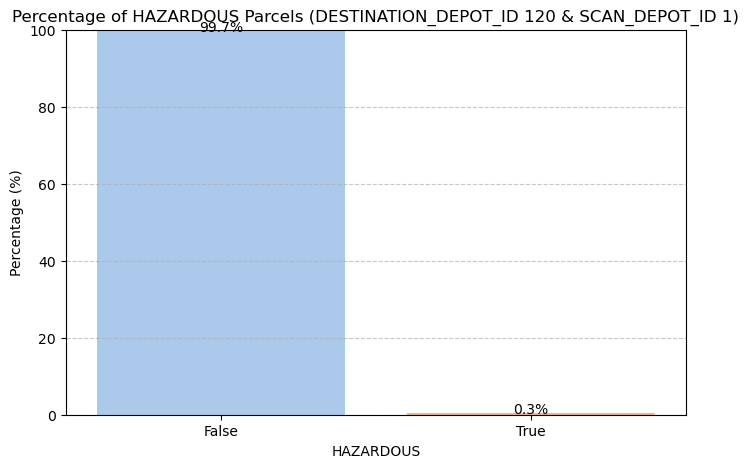

In [215]:
# Filter data for DESTINATION_DEPOT_ID 120 and SCAN_DEPOT_ID 850
filtered_data = df_unique[(df_unique['DESTINATION_DEPOT_ID'] == 120) & (df_unique['SCAN_DEPOT_ID'] == 850)]

# Calculate the counts of True and False in the SMALL column
hazardous_counts = filtered_data['HAZARDOUS'].value_counts(normalize=True).reset_index()
hazardous_counts.columns = ['HAZARDOUS', 'Percentage']

# Convert the percentage to a range from 0 to 100
hazardous_counts['Percentage'] *= 100

# Plot the data
plt.figure(figsize=(8, 5))
barplot = sns.barplot(x='HAZARDOUS', y='Percentage', data=hazardous_counts, palette='pastel')
plt.title('Percentage of HAZARDOUS Parcels (DESTINATION_DEPOT_ID 120 & SCAN_DEPOT_ID 1)')
plt.xlabel('HAZARDOUS')
plt.ylabel('Percentage (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([0, 1], ['False', 'True'])  # Label the x-axis correctly
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100

# Add percentage labels on top of the bars
for index, row in hazardous_counts.iterrows():
    barplot.text(row.name, row['Percentage'], f"{row['Percentage']:.1f}%", color='black', ha="center")

plt.show()

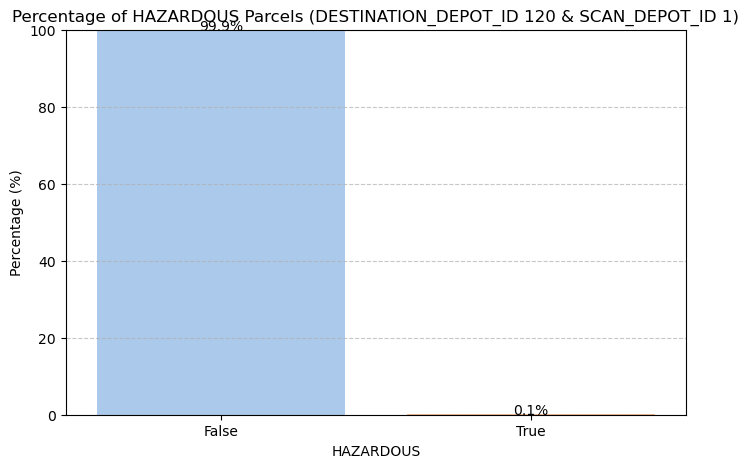

In [217]:
# Filter data for DESTINATION_DEPOT_ID 120 and SCAN_DEPOT_ID 110
filtered_data = df_unique[(df_unique['DESTINATION_DEPOT_ID'] == 120) & (df_unique['SCAN_DEPOT_ID'] == 110)]

# Calculate the counts of True and False in the SMALL column
hazardous_counts = filtered_data['HAZARDOUS'].value_counts(normalize=True).reset_index()
hazardous_counts.columns = ['HAZARDOUS', 'Percentage']

# Convert the percentage to a range from 0 to 100
hazardous_counts['Percentage'] *= 100

# Plot the data
plt.figure(figsize=(8, 5))
barplot = sns.barplot(x='HAZARDOUS', y='Percentage', data=hazardous_counts, palette='pastel')
plt.title('Percentage of HAZARDOUS Parcels (DESTINATION_DEPOT_ID 120 & SCAN_DEPOT_ID 1)')
plt.xlabel('HAZARDOUS')
plt.ylabel('Percentage (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([0, 1], ['False', 'True'])  # Label the x-axis correctly
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100

# Add percentage labels on top of the bars
for index, row in hazardous_counts.iterrows():
    barplot.text(row.name, row['Percentage'], f"{row['Percentage']:.1f}%", color='black', ha="center")

plt.show()

All 3 depots have over 99% parcels that are not hazardous. So this might be irrelevant.

# Day of the week

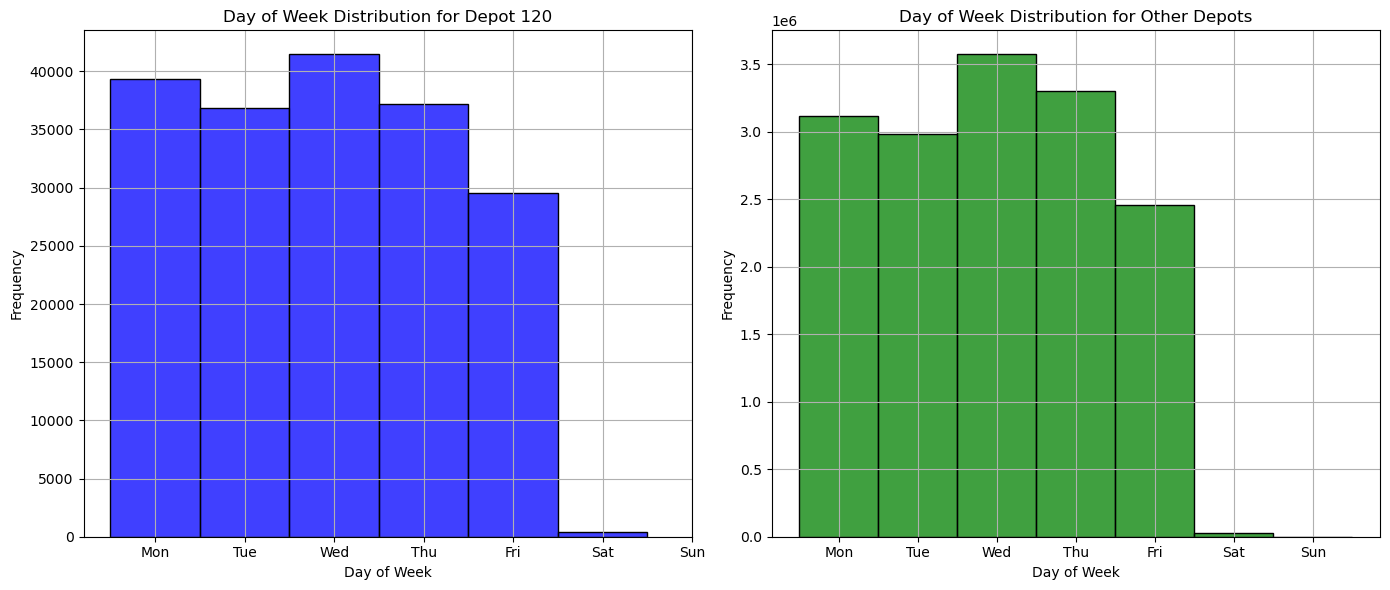

In [254]:
# Filter data for DESTINATION_DEPOT_ID 120
data_depot_120 = df_unique[df_unique['DESTINATION_DEPOT_ID'] == 120]
data_other_depots = df_unique[df_unique['DESTINATION_DEPOT_ID'] != 120]

# Plot the distribution of SCAN_DAY_OF_WEEK for depot 120
plt.figure(figsize=(14, 6))

# Plot for depot 120
plt.subplot(1, 2, 1)
sns.histplot(data_depot_120['SCAN_DAY_OF_WEEK'], bins=7, kde=False, color='blue', discrete=True)
plt.title('Day of Week Distribution for Depot 120')
plt.xlabel('Day of Week')
plt.ylabel('Frequency')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True)

# Plot for other depots
plt.subplot(1, 2, 2)
sns.histplot(data_other_depots['SCAN_DAY_OF_WEEK'], bins=7, kde=False, color='green', discrete=True)
plt.title('Day of Week Distribution for Other Depots')
plt.xlabel('Day of Week')
plt.ylabel('Frequency')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True)

plt.tight_layout()
plt.show()


We get similar distributions. 

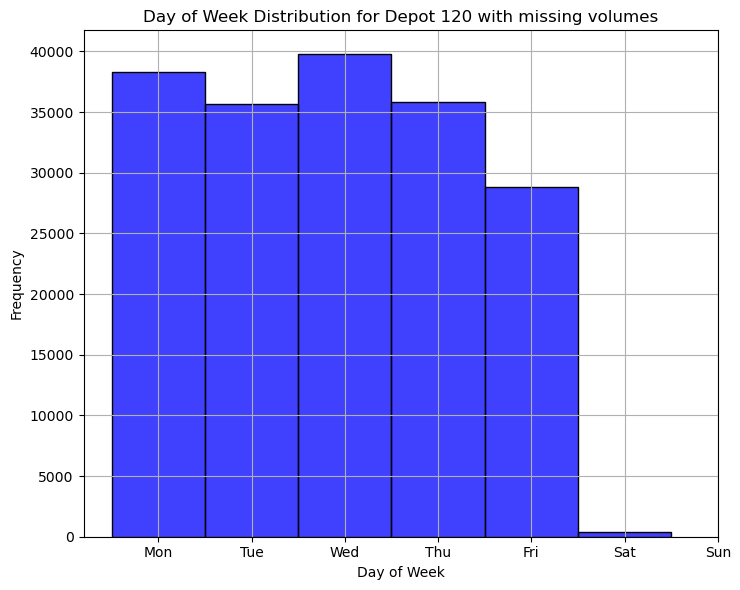

In [301]:
# Filter data for DESTINATION_DEPOT_ID 120
data_depot_120 = df_unique[(df_unique['DESTINATION_DEPOT_ID'] == 120) & (df_unique['VOLUME'].isna())]

# Plot the distribution of SCAN_DAY_OF_WEEK for depot 120
plt.figure(figsize=(14, 6))

# Plot for depot 120
plt.subplot(1, 2, 1)
sns.histplot(data_depot_120['SCAN_DAY_OF_WEEK'], bins=7, kde=False, color='blue', discrete=True)
plt.title('Day of Week Distribution for Depot 120 with missing volumes')
plt.xlabel('Day of Week')
plt.ylabel('Frequency')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True)

plt.tight_layout()
plt.show()

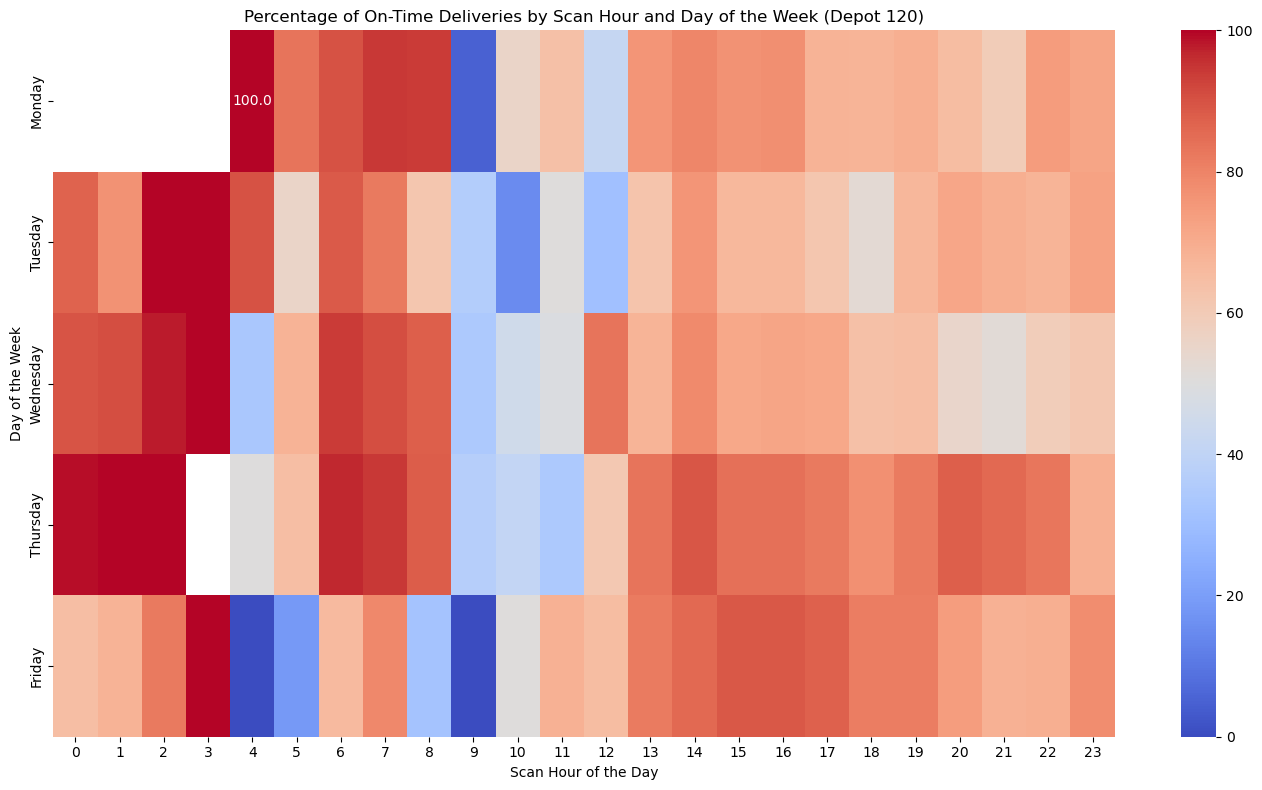

In [257]:
# Convert 'SCAN_DAY_OF_WEEK' from integer to day names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_unique['SCAN_DAY_NAME'] = df_unique['SCAN_DAY_OF_WEEK'].map(lambda x: day_names[x])

# Filter data for DESTINATION_DEPOT_ID 120
data_depot_120 = df_unique[df_unique['DESTINATION_DEPOT_ID'] == 120]

# Exclude Saturday and Sunday
data_depot_120 = data_depot_120[~data_depot_120['SCAN_DAY_NAME'].isin(['Saturday', 'Sunday'])]

# Ensure 'SCAN_DAY_NAME' is a categorical type with proper ordering
data_depot_120['SCAN_DAY_NAME'] = data_depot_120['SCAN_DAY_NAME'].astype(pd.CategoricalDtype(categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'
], ordered=True))

# Group by 'SCAN_HOUR' and 'SCAN_DAY_NAME' and calculate the percentage of on-time deliveries
on_time_counts_120 = data_depot_120.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME'])['ON_TIME'].sum()
total_counts_120 = data_depot_120.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME']).size()
percentage_on_time_120 = (on_time_counts_120 / total_counts_120) * 100

# Create a DataFrame for plotting
heatmap_data_120 = pd.DataFrame({
    'SCAN_HOUR': percentage_on_time_120.index.get_level_values('SCAN_HOUR'),
    'SCAN_DAY_NAME': percentage_on_time_120.index.get_level_values('SCAN_DAY_NAME'),
    'Percentage_On_Time': percentage_on_time_120.values
})

# Pivot the data for heatmap
heatmap_pivot_120 = heatmap_data_120.pivot(index='SCAN_DAY_NAME', columns='SCAN_HOUR', values='Percentage_On_Time')

# Ensure correct ordering of columns and index
heatmap_pivot_120 = heatmap_pivot_120.reindex(
    columns=range(24),  # Assuming hours from 0 to 23
    index=pd.CategoricalIndex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        ordered=True
    )
)

# Plotting for Depot 120
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_pivot_120, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, vmin=0, vmax=100)

# Customize the plot
plt.xlabel('Scan Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Percentage of On-Time Deliveries by Scan Hour and Day of the Week (Depot 120)')

# Show the plot
plt.tight_layout()
plt.show()

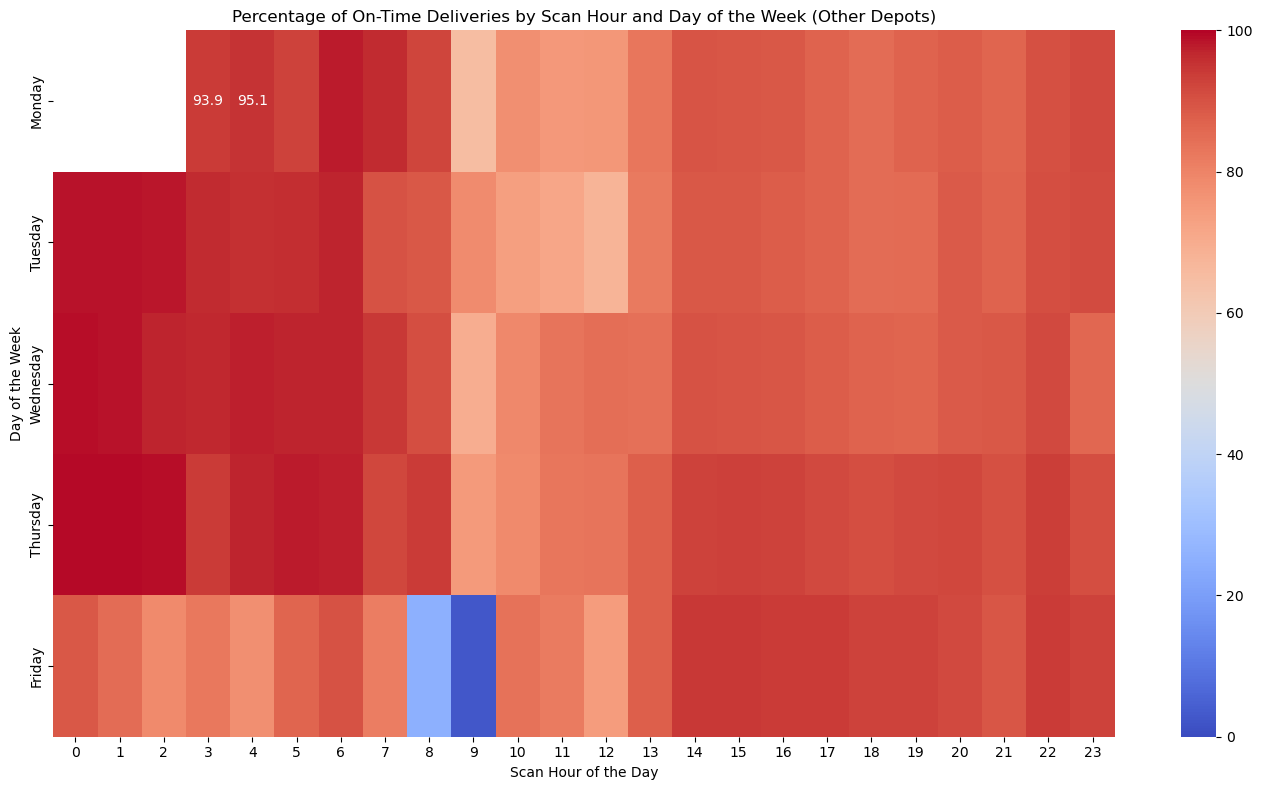

In [259]:
# Filter data for all other depots
data_other_depots = df_unique[df_unique['DESTINATION_DEPOT_ID'] != 120]

# Exclude Saturday and Sunday
data_other_depots = data_other_depots[~data_other_depots['SCAN_DAY_NAME'].isin(['Saturday', 'Sunday'])]

# Ensure 'SCAN_DAY_NAME' is a categorical type with proper ordering
data_other_depots['SCAN_DAY_NAME'] = data_other_depots['SCAN_DAY_NAME'].astype(pd.CategoricalDtype(categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'
], ordered=True))

# Group by 'SCAN_HOUR' and 'SCAN_DAY_NAME' and calculate the percentage of on-time deliveries
on_time_counts_other = data_other_depots.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME'])['ON_TIME'].sum()
total_counts_other = data_other_depots.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME']).size()
percentage_on_time_other = (on_time_counts_other / total_counts_other) * 100

# Create a DataFrame for plotting
heatmap_data_other = pd.DataFrame({
    'SCAN_HOUR': percentage_on_time_other.index.get_level_values('SCAN_HOUR'),
    'SCAN_DAY_NAME': percentage_on_time_other.index.get_level_values('SCAN_DAY_NAME'),
    'Percentage_On_Time': percentage_on_time_other.values
})

# Pivot the data for heatmap
heatmap_pivot_other = heatmap_data_other.pivot(index='SCAN_DAY_NAME', columns='SCAN_HOUR', values='Percentage_On_Time')

# Ensure correct ordering of columns and index
heatmap_pivot_other = heatmap_pivot_other.reindex(
    columns=range(24),  # Assuming hours from 0 to 23
    index=pd.CategoricalIndex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        ordered=True
    )
)

# Plotting for Other Depots
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_pivot_other, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, vmin=0, vmax=100)

# Customize the plot
plt.xlabel('Scan Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Percentage of On-Time Deliveries by Scan Hour and Day of the Week (Other Depots)')

# Show the plot
plt.tight_layout()
plt.show()

#### Comparing depot 120 and all the other depots, we see that depot 120 has very low on time deliveries between 9 and 10 and this trend does not exist for other depots. What can explain it?

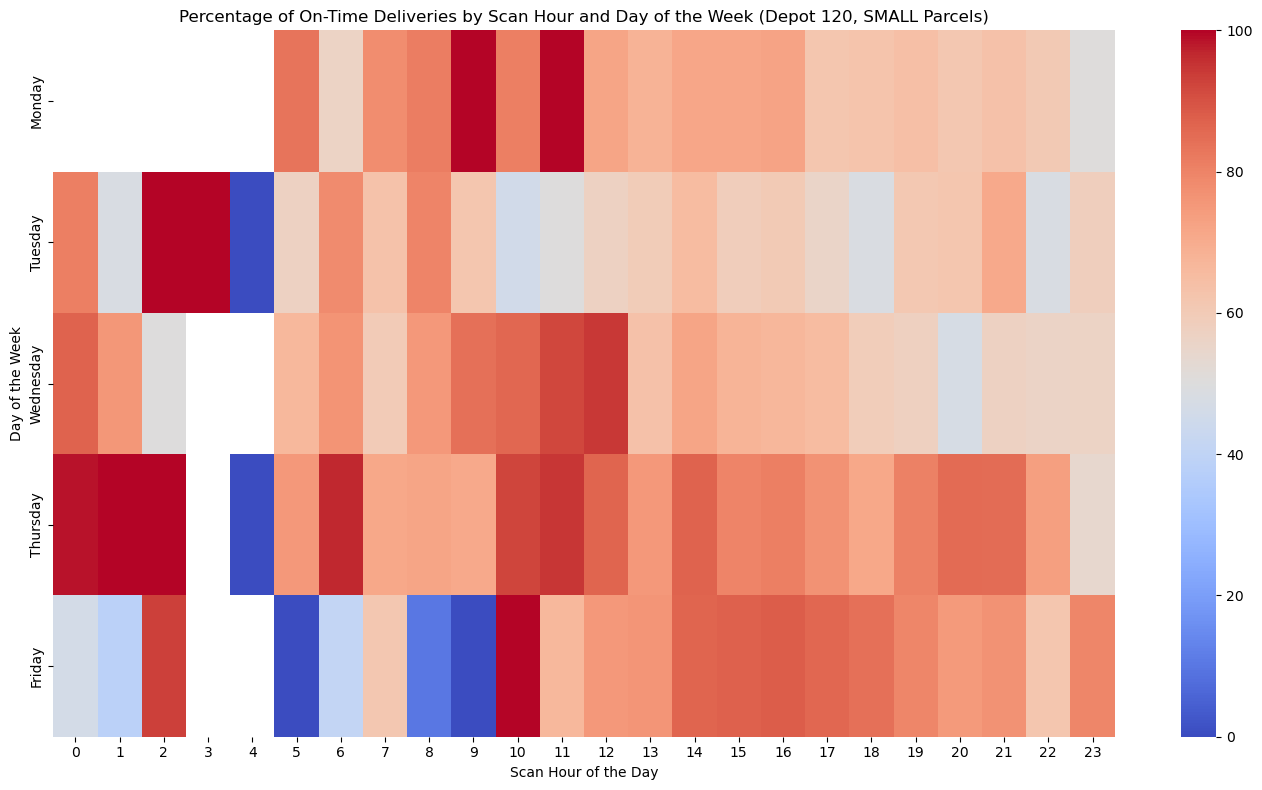

In [269]:
# Filter data for DESTINATION_DEPOT_ID 120 and where SMALL is True
data_depot_120_small = df_unique[(df_unique['DESTINATION_DEPOT_ID'] == 120) & (df_unique['SMALL'] == True)]

# Exclude Saturday and Sunday
data_depot_120_small = data_depot_120_small[~data_depot_120_small['SCAN_DAY_NAME'].isin(['Saturday', 'Sunday'])]

# Ensure 'SCAN_DAY_NAME' is a categorical type with proper ordering
data_depot_120_small['SCAN_DAY_NAME'] = data_depot_120_small['SCAN_DAY_NAME'].astype(pd.CategoricalDtype(categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'
], ordered=True))

# Group by 'SCAN_HOUR' and 'SCAN_DAY_NAME' and calculate the percentage of on-time deliveries
on_time_counts_depot_120_small = data_depot_120_small.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME'])['ON_TIME'].sum()
total_counts_depot_120_small = data_depot_120_small.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME']).size()
percentage_on_time_depot_120_small = (on_time_counts_depot_120_small / total_counts_depot_120_small) * 100

# Create a DataFrame for plotting
heatmap_data_depot_120_small = pd.DataFrame({
    'SCAN_HOUR': percentage_on_time_depot_120_small.index.get_level_values('SCAN_HOUR'),
    'SCAN_DAY_NAME': percentage_on_time_depot_120_small.index.get_level_values('SCAN_DAY_NAME'),
    'Percentage_On_Time': percentage_on_time_depot_120_small.values
})

# Pivot the data for heatmap
heatmap_pivot_depot_120_small = heatmap_data_depot_120_small.pivot(index='SCAN_DAY_NAME', columns='SCAN_HOUR', values='Percentage_On_Time')

# Ensure correct ordering of columns and index
heatmap_pivot_depot_120_small = heatmap_pivot_depot_120_small.reindex(
    columns=range(24),  # Assuming hours from 0 to 23
    index=pd.CategoricalIndex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        ordered=True
    )
)

# Plotting for Depot 120 and SMALL Parcels
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_pivot_depot_120_small, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, vmin=0, vmax=100)

# Customize the plot
plt.xlabel('Scan Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Percentage of On-Time Deliveries by Scan Hour and Day of the Week (Depot 120, SMALL Parcels)')

# Show the plot
plt.tight_layout()
plt.show()

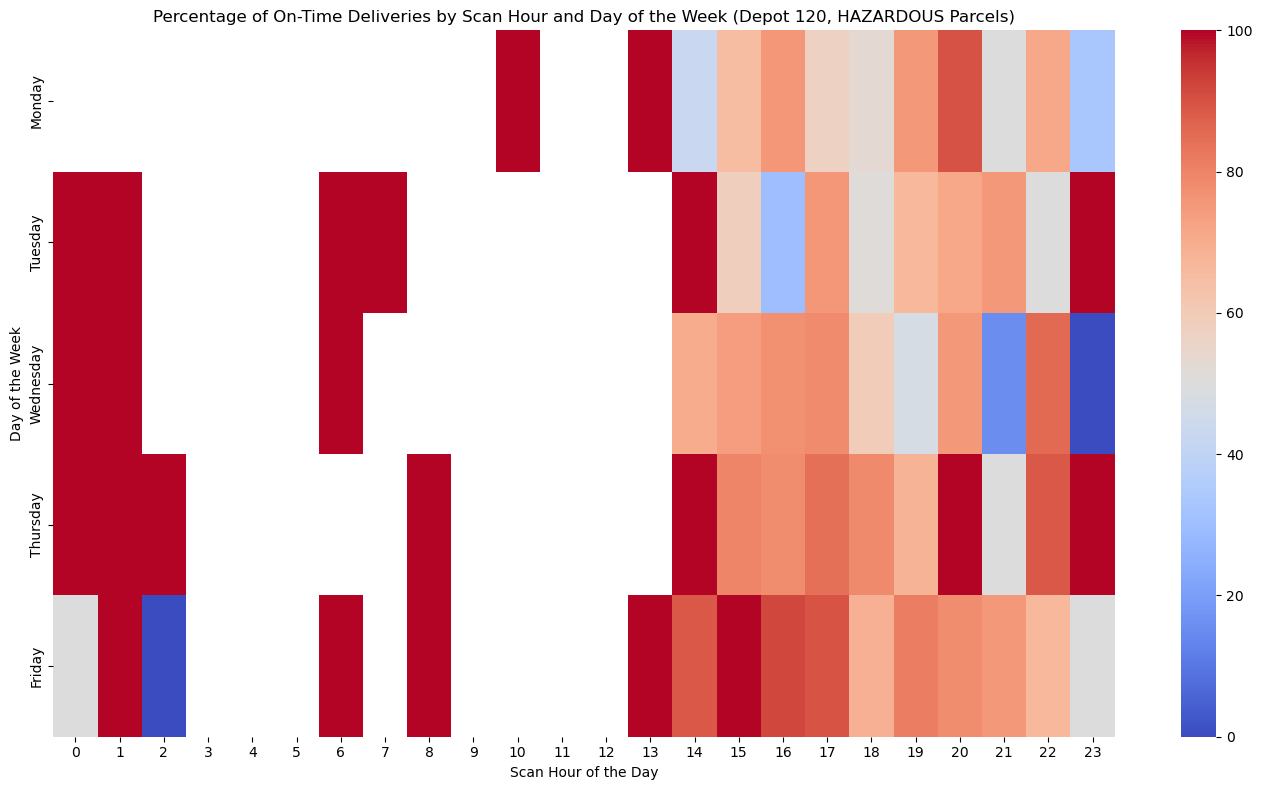

In [271]:
# Filter data for DESTINATION_DEPOT_ID 120 and where HAZARDOUS is True
data_depot_120_hazardous = df_unique[(df_unique['DESTINATION_DEPOT_ID'] == 120) & (df_unique['HAZARDOUS'] == True)]

# Exclude Saturday and Sunday
data_depot_120_hazardous = data_depot_120_hazardous[~data_depot_120_hazardous['SCAN_DAY_NAME'].isin(['Saturday', 'Sunday'])]

# Ensure 'SCAN_DAY_NAME' is a categorical type with proper ordering
data_depot_120_hazardous['SCAN_DAY_NAME'] = data_depot_120_hazardous['SCAN_DAY_NAME'].astype(pd.CategoricalDtype(categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'
], ordered=True))

# Group by 'SCAN_HOUR' and 'SCAN_DAY_NAME' and calculate the percentage of on-time deliveries
on_time_counts_depot_120_hazardous = data_depot_120_hazardous.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME'])['ON_TIME'].sum()
total_counts_depot_120_hazardous = data_depot_120_hazardous.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME']).size()
percentage_on_time_depot_120_hazardous = (on_time_counts_depot_120_hazardous / total_counts_depot_120_hazardous) * 100

# Create a DataFrame for plotting
heatmap_data_depot_120_hazardous = pd.DataFrame({
    'SCAN_HOUR': percentage_on_time_depot_120_hazardous.index.get_level_values('SCAN_HOUR'),
    'SCAN_DAY_NAME': percentage_on_time_depot_120_hazardous.index.get_level_values('SCAN_DAY_NAME'),
    'Percentage_On_Time': percentage_on_time_depot_120_hazardous.values
})

# Pivot the data for heatmap
heatmap_pivot_depot_120_hazardous = heatmap_data_depot_120_hazardous.pivot(index='SCAN_DAY_NAME', columns='SCAN_HOUR', values='Percentage_On_Time')

# Ensure correct ordering of columns and index
heatmap_pivot_depot_120_hazardous = heatmap_pivot_depot_120_hazardous.reindex(
    columns=range(24),  # Assuming hours from 0 to 23
    index=pd.CategoricalIndex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        ordered=True
    )
)

# Plotting for Depot 120 and HAZARDOUS Parcels
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_pivot_depot_120_hazardous, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, vmin=0, vmax=100)

# Customize the plot
plt.xlabel('Scan Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Percentage of On-Time Deliveries by Scan Hour and Day of the Week (Depot 120, HAZARDOUS Parcels)')

# Show the plot
plt.tight_layout()
plt.show()

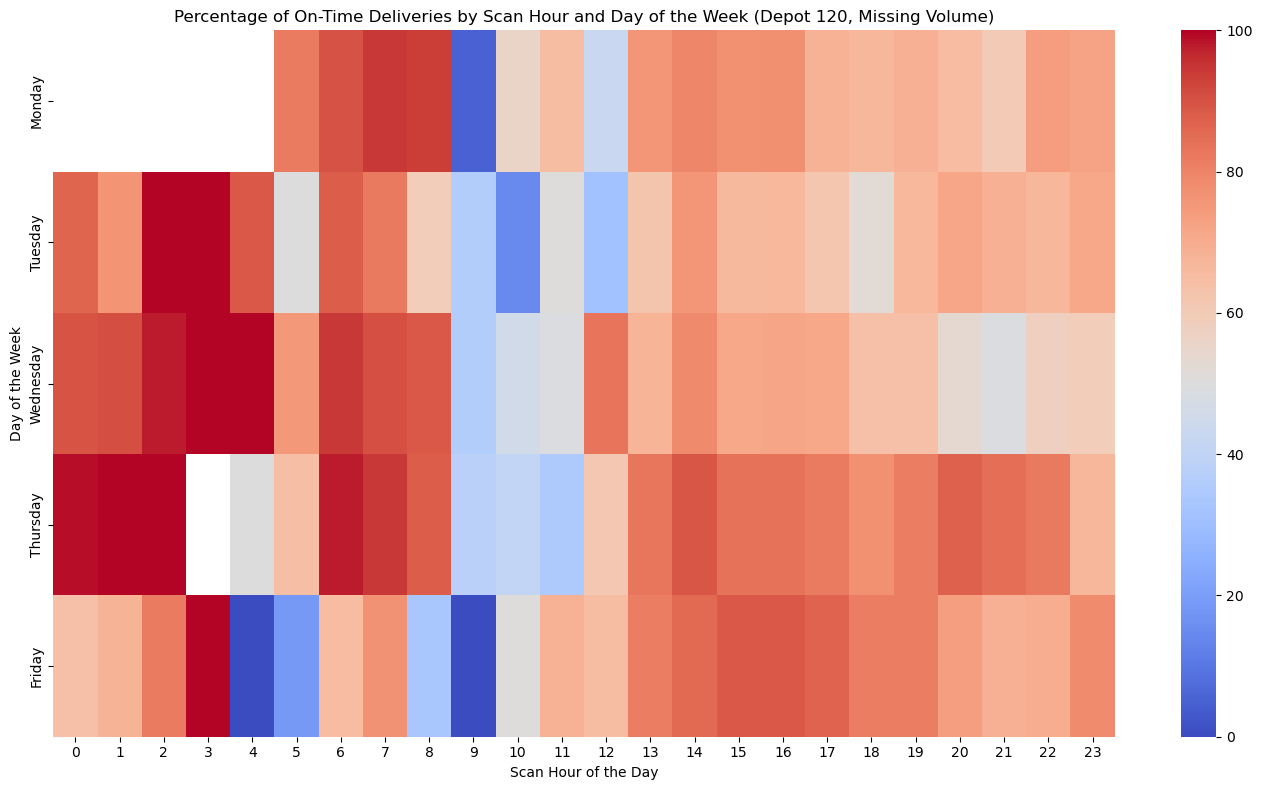

In [273]:
# Filter data for DESTINATION_DEPOT_ID 120 and where VOLUME is missing
data_depot_120_missing_volume = df_unique[(df_unique['DESTINATION_DEPOT_ID'] == 120) & (df_unique['VOLUME'].isna())]

# Exclude Saturday and Sunday
data_depot_120_missing_volume = data_depot_120_missing_volume[~data_depot_120_missing_volume['SCAN_DAY_NAME'].isin(['Saturday', 'Sunday'])]

# Ensure 'SCAN_DAY_NAME' is a categorical type with proper ordering
data_depot_120_missing_volume['SCAN_DAY_NAME'] = data_depot_120_missing_volume['SCAN_DAY_NAME'].astype(pd.CategoricalDtype(categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'
], ordered=True))

# Group by 'SCAN_HOUR' and 'SCAN_DAY_NAME' and calculate the percentage of on-time deliveries
on_time_counts_depot_120_missing_volume = data_depot_120_missing_volume.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME'])['ON_TIME'].sum()
total_counts_depot_120_missing_volume = data_depot_120_missing_volume.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME']).size()
percentage_on_time_depot_120_missing_volume = (on_time_counts_depot_120_missing_volume / total_counts_depot_120_missing_volume) * 100

# Create a DataFrame for plotting
heatmap_data_depot_120_missing_volume = pd.DataFrame({
    'SCAN_HOUR': percentage_on_time_depot_120_missing_volume.index.get_level_values('SCAN_HOUR'),
    'SCAN_DAY_NAME': percentage_on_time_depot_120_missing_volume.index.get_level_values('SCAN_DAY_NAME'),
    'Percentage_On_Time': percentage_on_time_depot_120_missing_volume.values
})

# Pivot the data for heatmap
heatmap_pivot_depot_120_missing_volume = heatmap_data_depot_120_missing_volume.pivot(index='SCAN_DAY_NAME', columns='SCAN_HOUR', values='Percentage_On_Time')

# Ensure correct ordering of columns and index
heatmap_pivot_depot_120_missing_volume = heatmap_pivot_depot_120_missing_volume.reindex(
    columns=range(24),  # Assuming hours from 0 to 23
    index=pd.CategoricalIndex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        ordered=True
    )
)

# Plotting for Depot 120 and Missing Volume Parcels
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_pivot_depot_120_missing_volume, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, vmin=0, vmax=100)

# Customize the plot
plt.xlabel('Scan Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Percentage of On-Time Deliveries by Scan Hour and Day of the Week (Depot 120, Missing Volume)')

# Show the plot
plt.tight_layout()
plt.show()

## THE PARCELS WITH MISSING VOLUMES MIGHT EXPLAIN THE TREND IN DEPOT 120 TO HAVE VERY LOW ON TIME DELIVERIES EVERY DAY OF THE WEEK BETWEEN 9 AND 10!

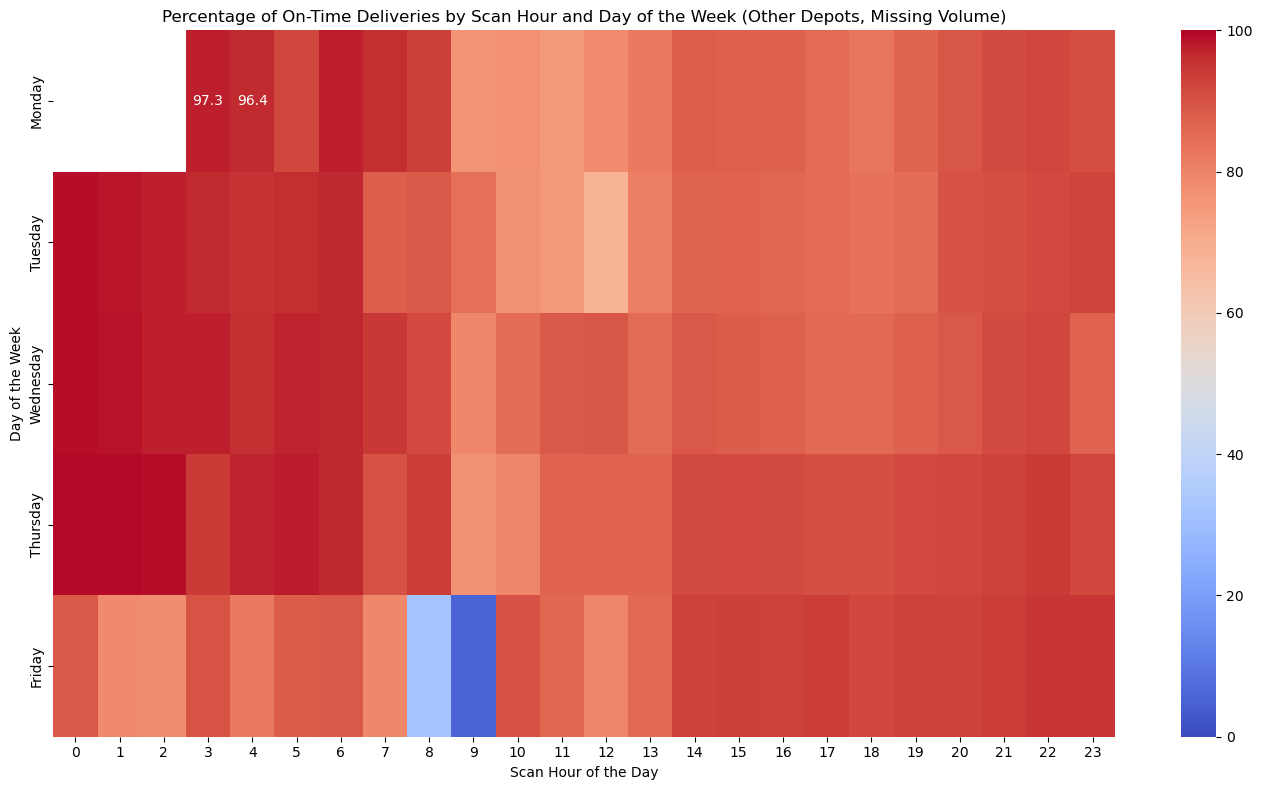

In [357]:
# Step 1: Filter out DESTINATION_DEPOT_ID 120 and where VOLUME is missing
data_other_depots_missing_volume = df_unique[(df_unique['DESTINATION_DEPOT_ID'] != 120) & (df_unique['VOLUME'].isna())]

# Step 2: Exclude Saturday and Sunday
data_other_depots_missing_volume = data_other_depots_missing_volume[~data_other_depots_missing_volume['SCAN_DAY_NAME'].isin(['Saturday', 'Sunday'])]

# Step 3: Ensure 'SCAN_DAY_NAME' is a categorical type with proper ordering
data_other_depots_missing_volume['SCAN_DAY_NAME'] = data_other_depots_missing_volume['SCAN_DAY_NAME'].astype(pd.CategoricalDtype(categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'
], ordered=True))

# Step 4: Group by 'SCAN_HOUR' and 'SCAN_DAY_NAME' and calculate the percentage of on-time deliveries
on_time_counts_other_depots_missing_volume = data_other_depots_missing_volume.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME'])['ON_TIME'].sum()
total_counts_other_depots_missing_volume = data_other_depots_missing_volume.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME']).size()
percentage_on_time_other_depots_missing_volume = (on_time_counts_other_depots_missing_volume / total_counts_other_depots_missing_volume) * 100

# Step 5: Create a DataFrame for plotting
heatmap_data_other_depots_missing_volume = pd.DataFrame({
    'SCAN_HOUR': percentage_on_time_other_depots_missing_volume.index.get_level_values('SCAN_HOUR'),
    'SCAN_DAY_NAME': percentage_on_time_other_depots_missing_volume.index.get_level_values('SCAN_DAY_NAME'),
    'Percentage_On_Time': percentage_on_time_other_depots_missing_volume.values
})

# Step 6: Pivot the data for heatmap
heatmap_pivot_other_depots_missing_volume = heatmap_data_other_depots_missing_volume.pivot(index='SCAN_DAY_NAME', columns='SCAN_HOUR', values='Percentage_On_Time')

# Ensure correct ordering of columns and index
heatmap_pivot_other_depots_missing_volume = heatmap_pivot_other_depots_missing_volume.reindex(
    columns=range(24),  # Assuming hours from 0 to 23
    index=pd.CategoricalIndex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        ordered=True
    )
)

# Step 7: Plotting for other depots with Missing Volume Parcels
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_pivot_other_depots_missing_volume, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, vmin=0, vmax=100)

# Customize the plot
plt.xlabel('Scan Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Percentage of On-Time Deliveries by Scan Hour and Day of the Week (Other Depots, Missing Volume)')

# Show the plot
plt.tight_layout()
plt.show()

The trend cannot be found in other depots so it is specific to depot 120.

# Where are the parcels with missing volume coming from? Which SCAN_DEPOT_ID?

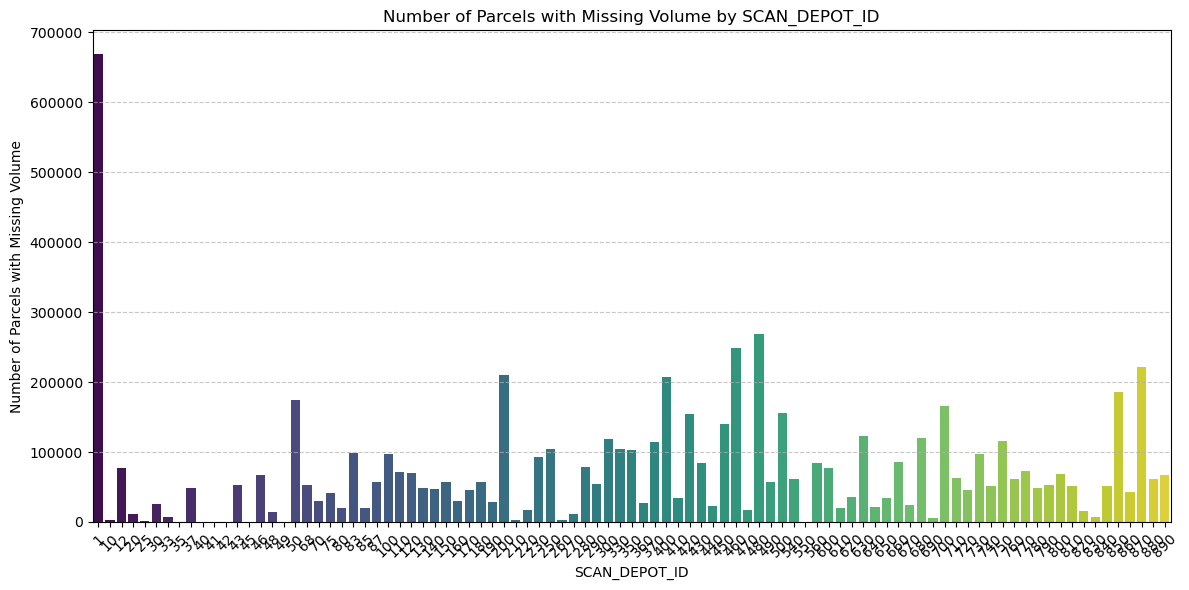

In [278]:
# Ensure SCAN_DATETIME is in datetime format
df_unique['SCAN_DATETIME'] = pd.to_datetime(df_unique['SCAN_DATETIME'])

# Filter data for parcels with missing volume
missing_volume_data = df_unique[df_unique['VOLUME'].isna()]

# Count the number of observations for each SCAN_DEPOT_ID with missing volume
missing_volume_counts = missing_volume_data['SCAN_DEPOT_ID'].value_counts().reset_index()
missing_volume_counts.columns = ['SCAN_DEPOT_ID', 'Count']

# Plotting the data
plt.figure(figsize=(12, 6))
sns.barplot(x='SCAN_DEPOT_ID', y='Count', data=missing_volume_counts, palette='viridis')
plt.title('Number of Parcels with Missing Volume by SCAN_DEPOT_ID')
plt.xlabel('SCAN_DEPOT_ID')
plt.ylabel('Number of Parcels with Missing Volume')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

Here we see a lot are from depot 1 but a lot of parcels in general are in depot 1, so lets check percentages!

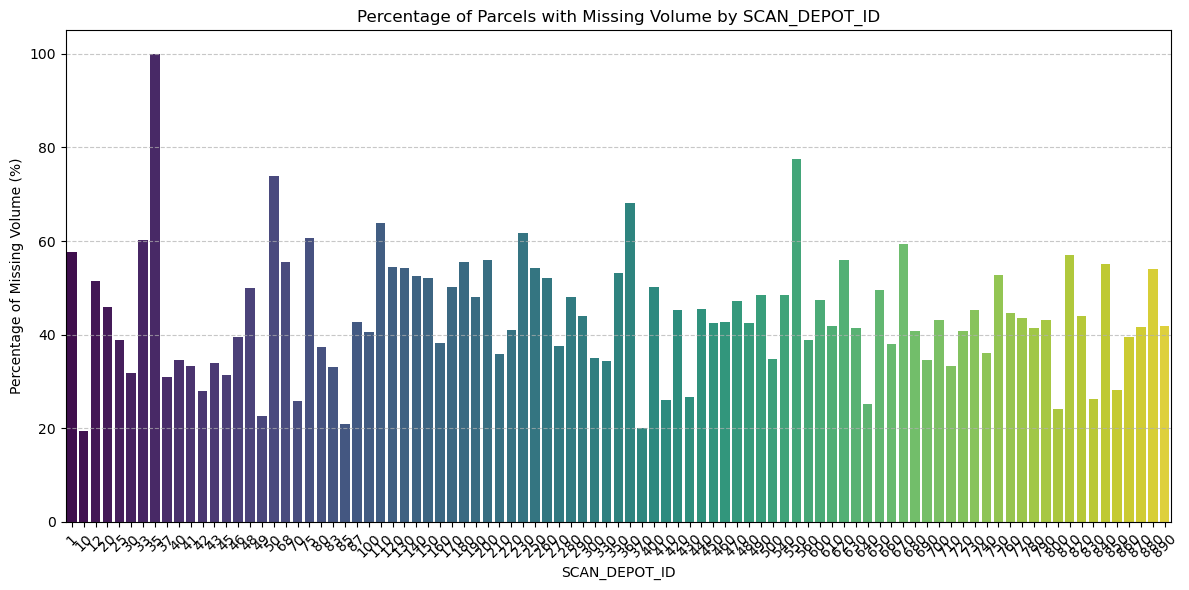

In [281]:
# Filter data for parcels with missing volume
missing_volume_data = df_unique[df_unique['VOLUME'].isna()]

# Calculate total number of parcels for each SCAN_DEPOT_ID
total_counts = df_unique['SCAN_DEPOT_ID'].value_counts().reset_index()
total_counts.columns = ['SCAN_DEPOT_ID', 'Total_Count']

# Count the number of missing volume parcels for each SCAN_DEPOT_ID
missing_volume_counts = missing_volume_data['SCAN_DEPOT_ID'].value_counts().reset_index()
missing_volume_counts.columns = ['SCAN_DEPOT_ID', 'Missing_Count']

# Merge the total counts with missing volume counts
merged_counts = pd.merge(total_counts, missing_volume_counts, on='SCAN_DEPOT_ID', how='left')
merged_counts['Missing_Count'].fillna(0, inplace=True)  # Replace NaN with 0 for SCAN_DEPOT_IDs without missing volumes

# Calculate the percentage of missing volume parcels
merged_counts['Percentage'] = (merged_counts['Missing_Count'] / merged_counts['Total_Count']) * 100

# Plotting the data
plt.figure(figsize=(12, 6))
sns.barplot(x='SCAN_DEPOT_ID', y='Percentage', data=merged_counts, palette='viridis')
plt.title('Percentage of Parcels with Missing Volume by SCAN_DEPOT_ID')
plt.xlabel('SCAN_DEPOT_ID')
plt.ylabel('Percentage of Missing Volume (%)')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

We see that 100% of the parcels coming from depot 35 have missing parcels. Right after, we have a lot from depots 550 as well as depots 50

### What is special about depot 35?

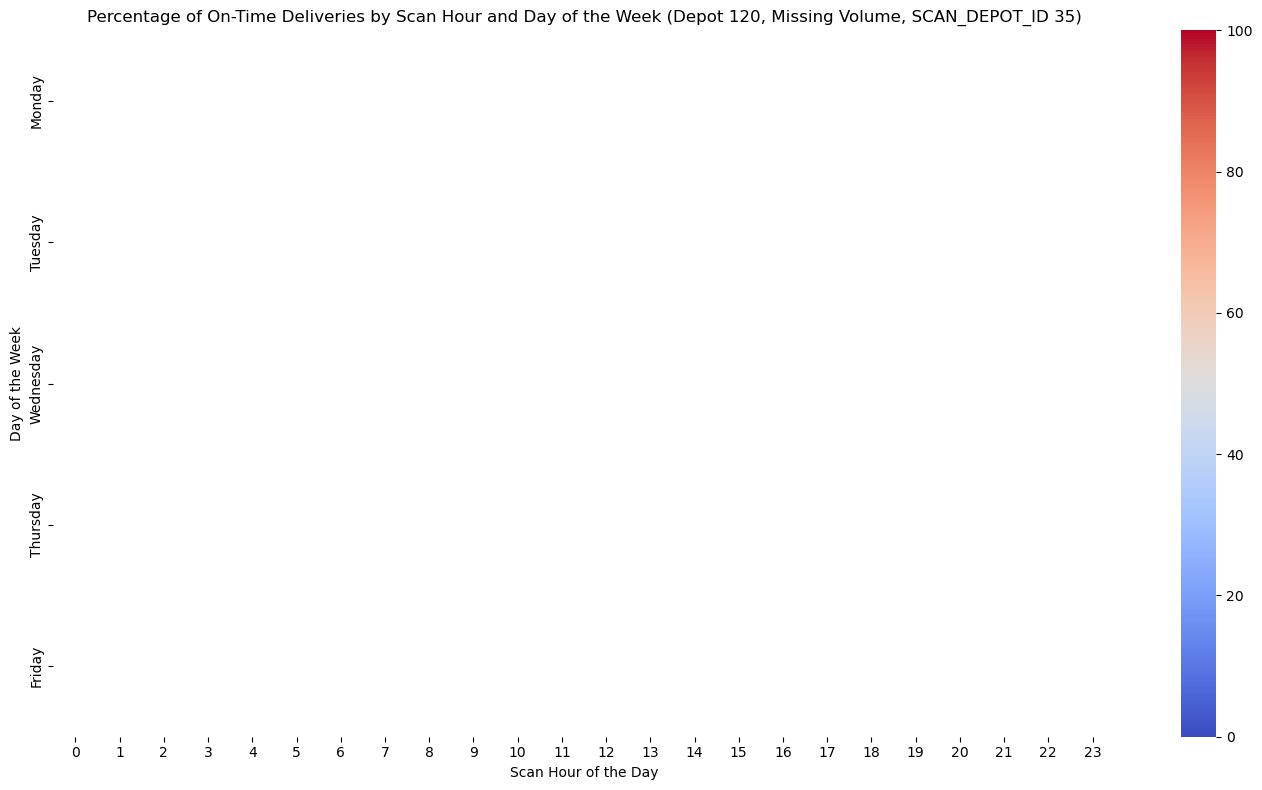

In [293]:
# Filter data for depot 120 and where VOLUME is missing, and SCAN_DEPOT_ID is 35
data_depot_120_missing_volume = df_unique[
    (df_unique['DESTINATION_DEPOT_ID'] == 120) &
    (df_unique['VOLUME'].isna()) &
    (df_unique['SCAN_DEPOT_ID'] == 35)
]

# Add columns for day of the week and hour of the day
data_depot_120_missing_volume['SCAN_DAY_OF_WEEK'] = data_depot_120_missing_volume['SCAN_DATETIME'].dt.dayofweek
data_depot_120_missing_volume['SCAN_DAY_NAME'] = data_depot_120_missing_volume['SCAN_DAY_OF_WEEK'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 
    5: 'Saturday', 6: 'Sunday'
})
data_depot_120_missing_volume['SCAN_HOUR'] = data_depot_120_missing_volume['SCAN_DATETIME'].dt.hour

# Exclude Saturday and Sunday
data_depot_120_missing_volume = data_depot_120_missing_volume[~data_depot_120_missing_volume['SCAN_DAY_NAME'].isin(['Saturday', 'Sunday'])]

# Ensure 'SCAN_DAY_NAME' is a categorical type with proper ordering
data_depot_120_missing_volume['SCAN_DAY_NAME'] = data_depot_120_missing_volume['SCAN_DAY_NAME'].astype(pd.CategoricalDtype(
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], ordered=True
))

# Group by 'SCAN_HOUR' and 'SCAN_DAY_NAME' and calculate the percentage of on-time deliveries
on_time_counts_depot_120_missing_volume = data_depot_120_missing_volume.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME'])['ON_TIME'].sum()
total_counts_depot_120_missing_volume = data_depot_120_missing_volume.groupby(['SCAN_HOUR', 'SCAN_DAY_NAME']).size()
percentage_on_time_depot_120_missing_volume = (on_time_counts_depot_120_missing_volume / total_counts_depot_120_missing_volume) * 100

# Create a DataFrame for plotting
heatmap_data_depot_120_missing_volume = pd.DataFrame({
    'SCAN_HOUR': percentage_on_time_depot_120_missing_volume.index.get_level_values('SCAN_HOUR'),
    'SCAN_DAY_NAME': percentage_on_time_depot_120_missing_volume.index.get_level_values('SCAN_DAY_NAME'),
    'Percentage_On_Time': percentage_on_time_depot_120_missing_volume.values
})

# Pivot the data for heatmap
heatmap_pivot_depot_120_missing_volume = heatmap_data_depot_120_missing_volume.pivot(index='SCAN_DAY_NAME', columns='SCAN_HOUR', values='Percentage_On_Time')

# Ensure correct ordering of columns and index
heatmap_pivot_depot_120_missing_volume = heatmap_pivot_depot_120_missing_volume.reindex(
    columns=range(24),  # Assuming hours from 0 to 23
    index=pd.CategoricalIndex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        ordered=True
    )
)

# Plotting for Depot 120 with Missing Volume and SCAN_DEPOT_ID 35
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_pivot_depot_120_missing_volume, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, vmin=0, vmax=100)

# Customize the plot
plt.xlabel('Scan Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Percentage of On-Time Deliveries by Scan Hour and Day of the Week (Depot 120, Missing Volume, SCAN_DEPOT_ID 35)')

# Show the plot
plt.tight_layout()
plt.show()


Depot 35 does not have enough data

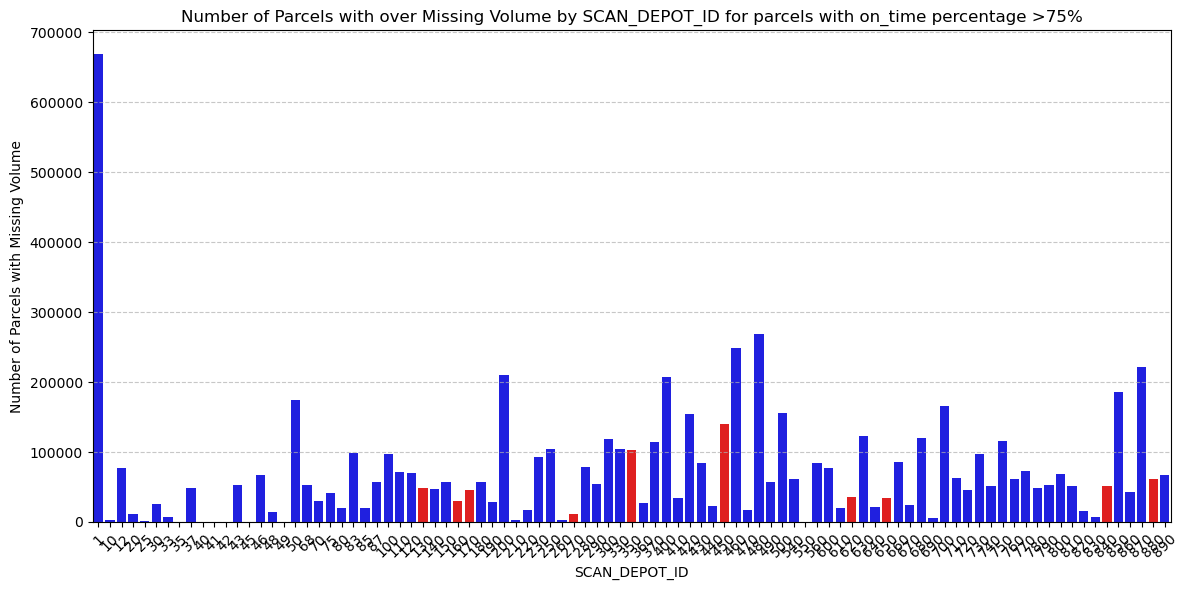

In [331]:
# Filter data for parcels with missing volume
missing_volume_data = df_unique[df_unique['VOLUME'].isna()]

# Count the number of observations for each SCAN_DEPOT_ID with missing volume
missing_volume_counts = missing_volume_data['SCAN_DEPOT_ID'].value_counts().reset_index()
missing_volume_counts.columns = ['SCAN_DEPOT_ID', 'Count']

# Calculate the true percentage of on-time deliveries for each SCAN_DEPOT_ID
on_time_counts = df_unique.groupby('SCAN_DEPOT_ID')['ON_TIME'].sum()
total_counts = df_unique.groupby('SCAN_DEPOT_ID').size()
on_time_percentage = (on_time_counts / total_counts) * 100

# Merge with the missing volume counts
missing_volume_counts = pd.merge(missing_volume_counts, on_time_percentage.reset_index(), on='SCAN_DEPOT_ID')
missing_volume_counts.columns = ['SCAN_DEPOT_ID', 'Count', 'On_Time_Percentage']

# Determine the color based on the On_Time_Percentage being less than 75%
missing_volume_counts['Color'] = missing_volume_counts['On_Time_Percentage'] < 75

# Plotting the data
plt.figure(figsize=(12, 6))
sns.barplot(x='SCAN_DEPOT_ID', y='Count', data=missing_volume_counts, palette=missing_volume_counts['Color'].map({True: 'red', False: 'blue'}))
plt.title('Number of Parcels with over Missing Volume by SCAN_DEPOT_ID for parcels with on_time percentage >75%')
plt.xlabel('SCAN_DEPOT_ID')
plt.ylabel('Number of Parcels with Missing Volume')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

 True (less than 75%) is assigned 'red', and False is assigned 'blue'. 

# Filtered for >75% Missing Volumes & <75% On-Time For depot 120

AttributeError: 'numpy.float64' object has no attribute 'startswith'

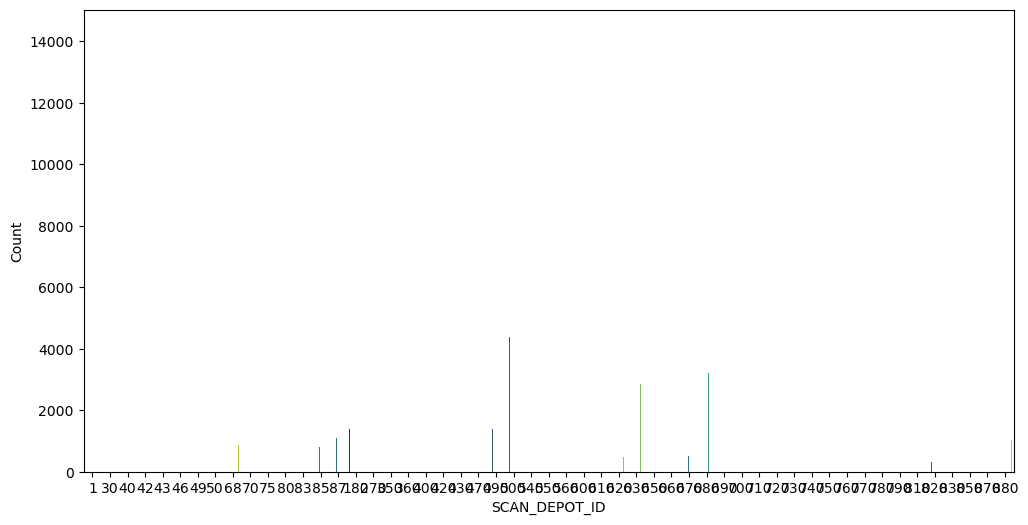

In [316]:
# Assuming 'On_Time' is a boolean column indicating if a delivery was on time (True) or not (False)
on_time_data = depot_120.groupby('SCAN_DEPOT_ID')['ON_TIME'].mean().reset_index()
on_time_data.columns = ['SCAN_DEPOT_ID', 'Percentage_ON_TIME']
on_time_data['Percentage_ON_TIME'] *= 100  # Convert to percentage

# Classify each SCAN_DEPOT_ID based on the percentage
on_time_data['Category'] = on_time_data['Percentage_ON_TIME'].apply(lambda x: 'Above 75%' if x > 95 else '75% or Below')

# If 'Volume' is the column and NaN indicates a missing volume
missing_volumes = depot_120.groupby('SCAN_DEPOT_ID')['VOLUME'].apply(lambda x: x.isna().mean() * 100).reset_index()
missing_volumes.columns = ['SCAN_DEPOT_ID', 'Percentage_Missing_Volumes']

# Merge the missing volumes data with the percentage on-time data
# Assuming percentage_on_time has columns 'SCAN_DEPOT_ID' and 'Percentage_ON_TIME'
filtered_data = pd.merge(missing_volumes, percentage_on_time, on='SCAN_DEPOT_ID')

# Filter to include only SCAN_DEPOT_IDs with both conditions:
# - Percentage_ON_TIME < 75%
# - Percentage_Missing_Volumes > 75%
final_filtered_data = filtered_data[
    (filtered_data['Percentage_ON_TIME'] < 75) &
    (filtered_data['Percentage_Missing_Volumes'] > 75)
]

# Count the number of observations for each filtered SCAN_DEPOT_ID
filtered_count = depot_120[depot_120['SCAN_DEPOT_ID'].isin(final_filtered_data['SCAN_DEPOT_ID'])]['SCAN_DEPOT_ID'].value_counts().reset_index()
filtered_count.columns = ['SCAN_DEPOT_ID', 'Count']

# Merge the count data with the final filtered data
plot_data = pd.merge(filtered_count, final_filtered_data, on='SCAN_DEPOT_ID')

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(x='SCAN_DEPOT_ID', y='Count', hue='Percentage_ON_TIME', data=plot_data, palette='viridis')
plt.title('Number of Observations by SCAN_DEPOT_ID (Filtered for >75% Missing Volumes & <75% On-Time)')
plt.xlabel('SCAN_DEPOT_ID')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.legend(title='Percentage_ON_TIME')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [318]:
# Display results as a table
print("Filtered Data:")
print(plot_data)


Filtered Data:
    SCAN_DEPOT_ID  Count  Percentage_Missing_Volumes  Percentage_ON_TIME  \
0               1  14309                   92.543155           74.771123   
1             850   6588                   97.176685           71.690953   
2             400   4949                   97.676298           60.860780   
3             870   4668                   92.802057           64.674379   
4             500   4367                   97.137623           45.156858   
5             700   3810                   95.748031           64.068241   
6             430   3743                   95.832220           61.528186   
7             420   3475                   98.618705           60.805755   
8              46   3217                   95.710289           70.500466   
9             680   3205                   97.410296           64.149766   
10            630   2866                   98.394976           70.027913   
11             83   2535                   97.593688           50.887574 

# For missing volumes >75% and true percentage <50%

In [328]:
# Further filter plot_data to include only those with Percentage_ON_TIME < 50%
plot_data_filtered = plot_data[plot_data['Percentage_ON_TIME'] < 50]

# Display results as a table
print("Filtered Data with Percentage_ON_TIME < 50%: in depot 120")
print(plot_data_filtered)

Filtered Data with Percentage_ON_TIME < 50%: in depot 120
    SCAN_DEPOT_ID  Count  Percentage_Missing_Volumes  Percentage_ON_TIME  \
4             500   4367                   97.137623           45.156858   
16             50   1900                   98.684211           33.368421   
21             43   1662                   95.487365           22.021661   
23            770   1556                   97.750643           39.203085   
25            180   1382                   93.560058           32.778582   
26            490   1376                   97.965116           47.238372   
27            760   1126                   98.312611           21.758437   
29            720   1085                   96.589862           49.124424   
30            780   1021                   97.159647           38.491675   
36            650    716                   94.553073           41.201117   
37             75    596                   97.818792           49.664430   
42            610    402      

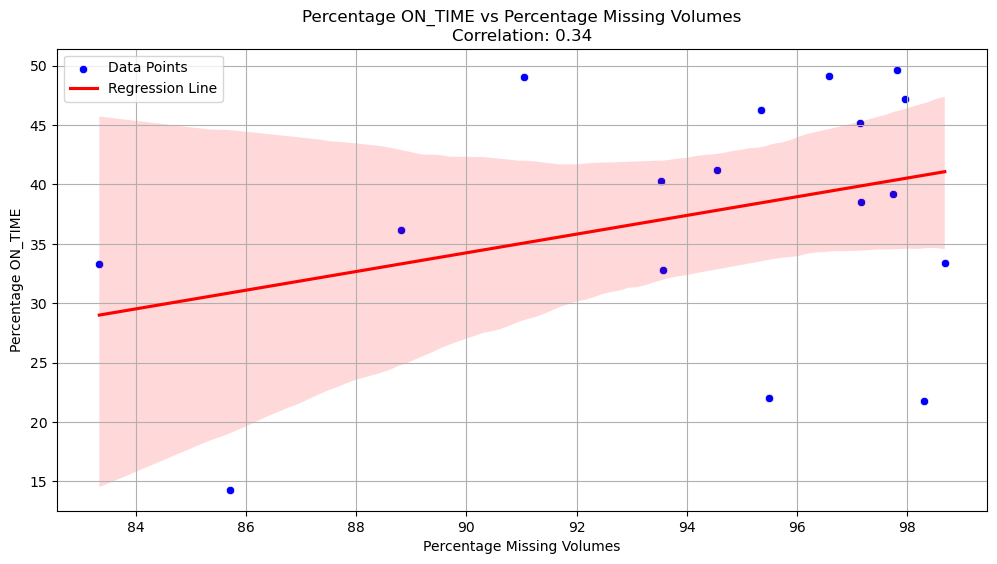

In [336]:
# Calculate the correlation
correlation = filtered_data_low_on_time[['Percentage_ON_TIME', 'Percentage_Missing_Volumes']].corr().iloc[0, 1]

# Plot the data
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Percentage_Missing_Volumes', y='Percentage_ON_TIME', data=filtered_data_low_on_time, color='blue', label='Data Points')

# Add a regression line
sns.regplot(x='Percentage_Missing_Volumes', y='Percentage_ON_TIME', data=filtered_data_low_on_time, scatter=False, color='red', label='Regression Line')

# Display the correlation on the plot
plt.title(f'Percentage ON_TIME vs Percentage Missing Volumes\nCorrelation: {correlation:.2f}')
plt.xlabel('Percentage Missing Volumes')
plt.ylabel('Percentage ON_TIME')
plt.legend()
plt.grid(True)
plt.show()

# If we look at specific SCAN_HOUR between 9 and 10

In [351]:
# Step 1: Filter for DESTINATION_DEPOT_ID == 120
filtered_df = df_unique[df_unique['DESTINATION_DEPOT_ID'] == 120]

# Step 2: Filter for SCAN_HOUR between 9 and 12 inclusive
filtered_df = filtered_df[filtered_df['SCAN_HOUR'].between(9, 10)]

# Step 3: Calculate Percentage_ON_TIME
# Assuming 'On_Time' is a boolean column where True represents on-time deliveries
percentage_on_time = filtered_df.groupby('SCAN_DEPOT_ID')['ON_TIME'].mean().reset_index()
percentage_on_time.columns = ['SCAN_DEPOT_ID', 'Percentage_ON_TIME']
percentage_on_time['Percentage_ON_TIME'] *= 100  # Convert to percentage

# Step 4: Merge the percentage on-time data back with the filtered DataFrame
filtered_df = pd.merge(filtered_df, percentage_on_time, on='SCAN_DEPOT_ID')

# Step 5: Calculate Percentage_Missing_Volumes
# Assuming 'Volume' can have NaNs representing missing volumes
percentage_missing_volumes = filtered_df.groupby('SCAN_DEPOT_ID')['VOLUME'].apply(lambda x: x.isna().mean() * 100).reset_index()
percentage_missing_volumes.columns = ['SCAN_DEPOT_ID', 'Percentage_Missing_Volumes']

# Merge the missing volumes data back with the filtered DataFrame
filtered_df = pd.merge(filtered_df, percentage_missing_volumes, on='SCAN_DEPOT_ID')

# Step 6: Apply the final filters
final_filtered_df = filtered_df[
    (filtered_df['Percentage_ON_TIME'] < 50) &
    (filtered_df['Percentage_Missing_Volumes'] > 75)
]

# Drop duplicate rows if needed, e.g., if there are multiple entries per SCAN_DEPOT_ID
final_filtered_df = final_filtered_df.drop_duplicates()

# Display the resulting DataFrame
print("Final Filtered DataFrame:")
print(final_filtered_df)

Final Filtered DataFrame:
           UNITNO           SCAN_DATETIME  EVENT_CODE  EVENT_REASON  WEIGHT  \
37    10843022745 2024-07-03 10:36:49.063           0             0    0.25   
45    11212724160 2024-07-15 09:33:21.280           0             0    1.00   
102   14351112337 2024-07-09 10:56:34.000           0             0    0.54   
162   18012589046 2024-07-03 09:06:31.000           0             0   12.40   
163   18012589059 2024-07-03 09:01:35.710           0             0    0.05   
164   18012589073 2024-07-03 09:03:00.995           0             0   19.95   
165   18400044687 2024-07-16 09:07:35.364           0             0    2.85   
166   18400044689 2024-07-16 09:02:58.635           0             0    1.54   
167   18400045131 2024-07-16 09:07:31.244           0             0   28.90   
168   18400045275 2024-07-16 09:00:04.496           0             0    4.80   
169   18400045722 2024-07-16 09:06:01.446           0             0    1.20   
210   27200367495 2024-07-

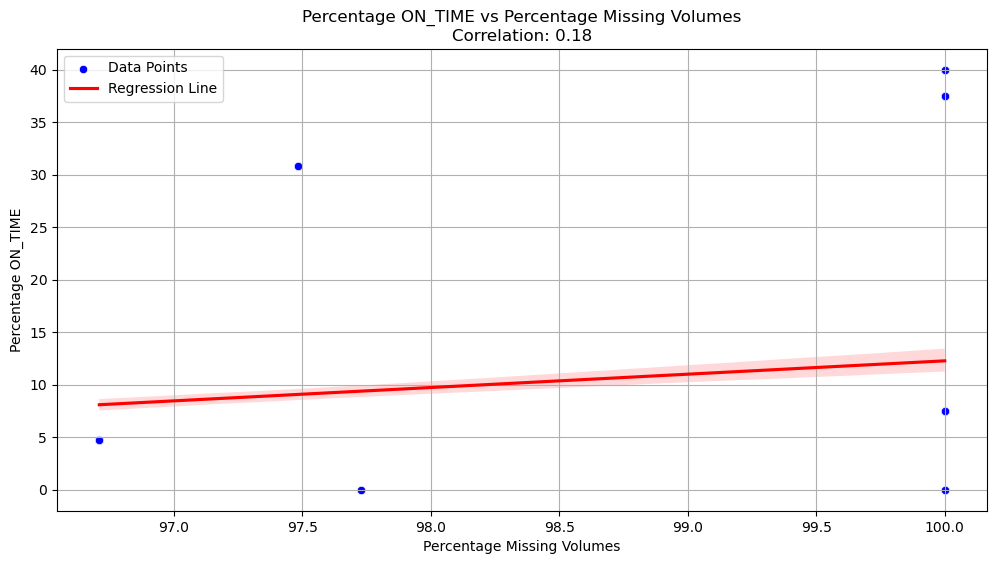

In [352]:
# Calculate the correlation
correlation = final_filtered_df[['Percentage_ON_TIME', 'Percentage_Missing_Volumes']].corr().iloc[0, 1]

# Plot the data
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Percentage_Missing_Volumes', y='Percentage_ON_TIME', data=final_filtered_df, color='blue', label='Data Points')

# Add a regression line
sns.regplot(x='Percentage_Missing_Volumes', y='Percentage_ON_TIME', data=final_filtered_df, scatter=False, color='red', label='Regression Line')

# Display the correlation on the plot
plt.title(f'Percentage ON_TIME vs Percentage Missing Volumes\nCorrelation: {correlation:.2f}')
plt.xlabel('Percentage Missing Volumes')
plt.ylabel('Percentage ON_TIME')
plt.legend()
plt.grid(True)
plt.show()

The worst hours of on_time delivery for depot 120 (between 9 and 10), show a weak positive relationship between Percentage_ON_TIME and Percentage_Missing_Volumes during hours 9 and 10. This means that as Percentage_Missing_Volumes increases, Percentage_ON_TIME tends to increase slightly as well, but the relationship is not strong.

# Is this still valid for other depots? with no time specification, missing volumes>50% and on time<50%

In [369]:
# Step 1: Filter out DESTINATION_DEPOT_ID == 120
filtered_df = df_unique[df_unique['DESTINATION_DEPOT_ID'] != 120]

# Step 2: Calculate Percentage_ON_TIME
# Assuming 'ON_TIME' is a boolean column where True represents on-time deliveries
percentage_on_time = filtered_df.groupby('DESTINATION_DEPOT_ID')['ON_TIME'].mean().reset_index()
percentage_on_time.columns = ['DESTINATION_DEPOT_ID', 'Percentage_ON_TIME']
percentage_on_time['Percentage_ON_TIME'] *= 100  # Convert to percentage

# Step 3: Calculate Percentage_Missing_Volumes
# Assuming 'VOLUME' can have NaNs representing missing volumes
percentage_missing_volumes = filtered_df.groupby('SCAN_DEPOT_ID')['VOLUME'].apply(lambda x: x.isna().mean() * 100).reset_index()
percentage_missing_volumes.columns = ['DESTINATION_DEPOT_ID', 'Percentage_Missing_Volumes']

# Merge the calculated percentages back with the filtered DataFrame
merged_df = pd.merge(percentage_on_time, percentage_missing_volumes, on='DESTINATION_DEPOT_ID')

# Step 4: Apply the final filters
final_filtered_df = merged_df[
    (merged_df['Percentage_ON_TIME'] < 50) &
    (merged_df['Percentage_Missing_Volumes'] > 50)
]

# Display the resulting DataFrame
print("Final Filtered DataFrame:")
print(final_filtered_df)

Final Filtered DataFrame:
    DESTINATION_DEPOT_ID  Percentage_ON_TIME  Percentage_Missing_Volumes
36                   550           48.684211                   77.504105


We only get one row as a result! So this trend is not relevant for other depots. 